In [467]:
import numpy as np
import pandas as pd
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import ttest_ind
import plotly.express as px
import db_dtypes
import bigframes.pandas as bpd
from IPython.display import display, HTML
import math
import statsmodels.api as sm
from typing import Union
import logging
import sys
from google.cloud.exceptions import NotFound
from datetime import datetime, timedelta
import time
import os
import json
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from google.auth import default 
import pandas as pd
from statsmodels.stats.multitest import multipletests
from geopy.geocoders import Nominatim
from geopy.exc import GeocoderTimedOut


# def test_data(var_split_created_at_start, var_split_created_at_end, var_days_lagged, var_test_id, var_entity_id, var_country_code):

#     test_session_data = f"""


#     WITH test_setups AS(
#         SELECT country_code, entity_id, test_name, test_id
#         FROM `fulfillment-dwh-production.cl.dps_experiment_setups`
#         GROUP BY country_code, entity_id, test_name, test_id
#     ), 
#     session as (
#     SELECT sessions.dh_platform
#         ,sessions.entity_id
#         ,sessions.country_code
#         ,sessions.created_at
#         ,sessions.created_date
#         ,sessions.session_id
#         ,sessions.perseus_client_id
#         ,sessions.customer_id
#         ,ce.id
#         ,ce.variant
#         ,ce.vertical_parent
#         ,total_transactions
#         ,pt.transaction_id
#     FROM `fulfillment-dwh-production.cl.dps_perseus_sessions` sessions
#     LEFT JOIN UNNEST(sessions.dps) AS dps
#     LEFT JOIN UNNEST(sessions.perseus_transactions) AS pt
#     LEFT JOIN UNNEST(dps.customer_experiments) AS ce
#     WHERE
#         ----------------------------------------------------------------
#         -- take into account the lag and the time of the traffic split
#         -- skip the first day of the test
#         ----------------------------------------------------------------
#         created_at BETWEEN
#             TIMESTAMP_SUB('{var_split_created_at_start}', INTERVAL {var_days_lagged} + 1 DAY)
#             AND
#             '{var_split_created_at_end}'
#         AND ce.id = {var_test_id}
#         AND sessions.entity_id = '{var_entity_id}'
#         AND lower(sessions.country_code) = '{var_country_code}'
#         AND (ce.variant ='Control' OR STARTS_WITH(ce.variant, 'Variation'))
#     group by 1,2,3,4,5,6,7,8,9, 10, 11, 12,13
#     ), 
#     setup_delivery_fee as (
#     select s.*
#         ,(case when variant = 'Control' then 1.89
#             when variant = 'Variation1' then 2.09
#             when variant = 'Variation2' then 1.69
#             when variant = 'Variation3' then 1.99
#             when variant = 'Variation4' then 1.79
#         else null end) as configured_df
#     from session s
#     )
#     select *
#     from setup_delivery_fee

#     """

#     return test_session_data



def test_data(var_split_created_at_start, var_split_created_at_end, var_days_lagged, var_test_id, var_entity_id, var_country_code):

    test_session_data = f"""
    
    WITH test_setups AS(
    SELECT country_code, entity_id, test_name, test_id
    FROM `fulfillment-dwh-production.cl.dps_experiment_setups`
    GROUP BY country_code, entity_id, test_name, test_id
    ), 
    session as (
    SELECT sessions.dh_platform
        ,sessions.entity_id
        ,sessions.country_code
        ,sessions.created_at
        ,sessions.created_date
        ,sessions.session_id
        ,sessions.perseus_client_id
        ,sessions.customer_id
        ,dps.customer_location
        ,ce.id
        ,ce.variant
        ,ce.vertical_parent
        ,total_transactions
        ,pt.transaction_id
    FROM `fulfillment-dwh-production.cl.dps_perseus_sessions` sessions
    LEFT JOIN UNNEST(sessions.dps) AS dps
    LEFT JOIN UNNEST(sessions.perseus_transactions) AS pt
    LEFT JOIN UNNEST(dps.customer_experiments) AS ce
    WHERE
        ----------------------------------------------------------------
        -- take into account the lag and the time of the traffic split
        -- skip the first day of the test
        ----------------------------------------------------------------
        created_at BETWEEN
            TIMESTAMP_ADD('{var_split_created_at_start}', INTERVAL {var_days_lagged} DAY)
            AND
            '{var_split_created_at_end}'
        AND ce.id = {var_test_id}
        AND sessions.entity_id = '{var_entity_id}'
        AND lower(sessions.country_code) = '{var_country_code}'
        AND (ce.variant ='Control' OR STARTS_WITH(ce.variant, 'Variation'))
        AND ce.id is not null
        AND (dps.is_customer_holdout is False or dps.is_customer_holdout is null)
    group by 1,2,3,4,5,6,7,8,9, 10, 11, 12,13, 14
    ), 
    setup_delivery_fee as (
    select s.*
        ,(case when variant = 'Control' then 1.89
            when variant = 'Variation1' then 2.09
            when variant = 'Variation2' then 1.69
            when variant = 'Variation3' then 1.99
            when variant = 'Variation4' then 1.79
        else null end) as configured_df
    from session s
    ),
    orders as (
    select s.*
        ,map.delivery_fee_eur
        ,map.dps_delivery_fee_eur
        ,map.profit_eur
        ,map.travel_time_distance_km
        ,map.travel_time
        ,map.platform_order_code
        ,map.gfv_eur
        ,map.gmv_eur
        ,map.delivery_costs_eur
        ,map.fully_loaded_gross_profit_eur
        ,map.has_subscription
        ,map.subscription_discount_type
    from setup_delivery_fee s
    LEFT JOIN `fulfillment-dwh-production.cl.dps_sessions_mapped_to_orders` map
        ON s.entity_id = map.entity_id
        AND s.session_id = map.fe_session_id
        AND s.perseus_client_id = map.perseus_client_id
        AND s.transaction_id = map.platform_order_code
    where (is_in_test or is_in_test is null)
        AND (is_customer_holdout is false or is_customer_holdout is null)
        AND subscription_discount_type is null
        AND (has_dps_incentive is false or has_dps_incentive is null)
        AND (is_own_delivery or is_own_delivery is null)
        AND (is_sent or is_sent is null)
        AND (is_df_discount_basket_value_deal is false or is_df_discount_basket_value_deal is null)
    )
    select *
    from orders
    where delivery_fee_eur = configured_df or delivery_fee_eur is null
    
    """

    return test_session_data

def initialize_bigquery_client(p_id):
   
    # Define your Google Cloud project ID
    project_id = p_id 

    logging.info(f"Initializing BigQuery client for project: {project_id}")

    # Initialize the BigQuery client with explicit credentials and project_id
    try:
        client = bigquery.Client(project=project_id)
        logging.info(f"BigQuery client initialized successfully for project: {project_id}")
        return client  # Return the BigQuery client for further use
    except Exception as e:
        logging.error(f"Failed to initialize BigQuery client: {e}")
        raise e

def check_null(df):

    return print(df.isna().sum())

def get_varying_columns_per_session(df, session_col):
    """
    Returns a dict mapping each session with >1 row to the list of columns 
    that vary within that session.
    """
    other_cols = [col for col in df.columns if col != session_col]
    session_counts = df[session_col].value_counts()
    duplicate_sessions = session_counts[session_counts > 1].index

    session_var_cols = {}
    for session in duplicate_sessions:
        group = df[df[session_col] == session]
        varying = [col for col in other_cols if group[col].nunique() > 1]
        if varying:
            session_var_cols[session] = varying

    return session_var_cols


def get_unique_varying_columns(df, session_col):
    """
    Returns a sorted list of unique columns that vary in any session 
    that has more than one row.
    """
    session_var_cols = get_varying_columns_per_session(df, session_col)
    unique_varying = set()
    for cols in session_var_cols.values():
        unique_varying.update(cols)
        
    print("Columns causing duplication across sessions:", sorted(unique_varying))


def detect_srm(df, day_col='day', variant_col='variant', count_col='count', alpha=0.05):
    """
    Detects SRM (Sample Ratio Mismatch) on a daily level from a dataframe.

    Parameters:
    - df: pandas DataFrame with columns for day, variant, and count
    - day_col: name of the column representing the day
    - variant_col: name of the column representing the variant
    - count_col: name of the column representing the session count
    - alpha: significance level to declare SRM (default 0.05)

    Returns:
    - A DataFrame with day, chi2_statistic, p_value, srm_detected,
      and percentage of total traffic for each variant.
    """
    results = []

    for day, group in df.groupby(day_col):
        variant_counts = group.set_index(variant_col)[count_col].to_dict()
        observed = list(variant_counts.values())
        variants = list(variant_counts.keys())

        n_total = sum(observed)
        k = len(observed)
        expected = [n_total / k] * k

        chi2_stat, p_value = stats.chisquare(f_obs=observed, f_exp=expected)
        srm_detected = p_value < alpha

        result = {
            day_col: day,
            'chi2_statistic': chi2_stat,
            'p_value': p_value,
            'srm_detected': srm_detected
        }

        # Add percentages only
        for variant, count in variant_counts.items():
            result[f'percent_{variant}'] = round(100 * count / n_total, 4)

        results.append(result)

    return pd.DataFrame(results)



def plot_srm_pvalues(srm_df, day_col='created_date', pvalue_col='p_value', alpha=0.05):
    """
    Plots SRM test p-values over time with a horizontal significance threshold.
    
    Parameters:
    - srm_df: DataFrame returned from detect_srm()
    - day_col: name of the day column
    - pvalue_col: name of the p-value column
    - alpha: threshold for significance (default 0.05)
    """
    plt.figure(figsize=(10, 5))
    plt.plot(srm_df[day_col], srm_df[pvalue_col], marker='o', label='p-value')
    plt.axhline(y=alpha, color='red', linestyle='--', label=f'α = {alpha}')
    plt.xlabel('Day')
    plt.ylabel('SRM p-value')
    plt.title('Daily SRM Test p-values')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


def plot_cumulative_cvr_by_variant(test_df):
    """
    Plots cumulative session-to-order conversion rate (CVR) over time by variant.

    Parameters:
        test_df (pd.DataFrame): Input DataFrame with columns 
            ['created_date', 'session_id', 'variant', 'configured_df', 'transaction_id']

    Returns:
        pd.DataFrame: The aggregated `daily_data` DataFrame used for plotting.
    """
    # Step 1: Aggregate by session to get conversion info
    agg_data = test_df.groupby(
        ['created_date', 'session_id', 'variant', 'configured_df']
    ).agg({'transaction_id': 'nunique'}).reset_index()

    # Step 2: Calculate daily session counts
    daily_data = agg_data.groupby(['created_date', 'variant', 'configured_df']).agg(
        total_sessions=('session_id', 'nunique'),
        converted_sessions=('transaction_id', lambda x: (x > 0).sum())
    ).reset_index()

    # Step 3: Sort and compute cumulative totals
    daily_data = daily_data.sort_values(by=['variant', 'created_date'])
    daily_data['cumulative_sessions'] = daily_data.groupby('variant')['total_sessions'].cumsum()
    daily_data['cumulative_converted'] = daily_data.groupby('variant')['converted_sessions'].cumsum()

    # Step 4: Compute cumulative CVR
    daily_data['cumulative_cvr'] = round(
        daily_data['cumulative_converted'] / daily_data['cumulative_sessions'], 4
    )

    # Step 5: Plot cumulative CVR
    plt.figure(figsize=(12, 6))
    for variant, group in daily_data.groupby('variant'):
        plt.plot(group['created_date'], group['cumulative_cvr'], marker='o', label=f'Variant {variant}')

    plt.title('Cumulative Session-to-Order Conversion Rate (CVR) by Variant')
    plt.xlabel('Created Date')
    plt.ylabel('Cumulative CVR')
    plt.legend(title='Variant')
    plt.grid(True)
    plt.tight_layout()
    plt.xticks(rotation=45)
    plt.show()
    
    return daily_data


# def detect_srm(df, day_col='day', variant_col='variant', count_col='count', alpha=0.05):
#     """
#     Detects SRM (Sample Ratio Mismatch) on a daily level from a dataframe.

#     Parameters:
#     - df: pandas DataFrame with columns for day, variant, and count
#     - day_col: name of the column representing the day
#     - variant_col: name of the column representing the variant
#     - count_col: name of the column representing the session count
#     - alpha: significance level to declare SRM (default 0.05)

#     Returns:
#     - A DataFrame with day, chi2_statistic, p_value, srm_detected,
#       counts for each variant, and their percentages of total.
#     """
#     results = []

#     for day, group in df.groupby(day_col):
#         variant_counts = group.set_index(variant_col)[count_col].to_dict()
#         variants = list(variant_counts.keys())
#         observed = list(variant_counts.values())

#         n_total = sum(observed)
#         k = len(observed)
#         expected = [n_total / k] * k

#         chi2_stat, p_value = stats.chisquare(f_obs=observed, f_exp=expected)
#         srm_detected = p_value < alpha

#         result = {
#             day_col: day,
#             'chi2_statistic': chi2_stat,
#             'p_value': p_value,
#             'srm_detected': srm_detected
#         }

#         # Add variant counts and percentages as separate columns
#         for variant, count in variant_counts.items():
#             result[f'count_{variant}'] = count
#             result[f'percent_{variant}'] = round(100 * count / n_total, 2)

#         results.append(result)

#     return pd.DataFrame(results)





In [470]:
# import pandas as pd
# from geopy.geocoders import Nominatim
# from geopy.exc import GeocoderTimedOut
# import time
# import re
# from tqdm import tqdm  # For progress bar (optional)

# # Setup
# geolocator = Nominatim(user_agent="geoapi")

# # Helper: parse 'POINT(lon lat)' → (lat, lon)
# def parse_point(point_str):
#     match = re.match(r'POINT\(([-\d.]+) ([-\d.]+)\)', point_str)
#     if match:
#         lon, lat = map(float, match.groups())
#         return (lat, lon)
#     return None

# # Robust reverse geocoding with retry
# def get_city_from_coords(coords, retries=3):
#     for i in range(retries):
#         try:
#             location = geolocator.reverse(coords, language="en", exactly_one=True, timeout=10)
#             if location and location.raw:
#                 address = location.raw.get('address', {})
#                 return address.get('city') or address.get('town') or address.get('village') or address.get('municipality')
#             return None
#         except GeocoderTimedOut:
#             time.sleep(1)
#         except Exception as e:
#             print(f"Error for {coords}: {e}")
#             return None
#     return None

# # Parse coordinates
# test_df['latlon'] = test_df['customer_location'].apply(parse_point)

# # Drop duplicates and reverse geocode only unique coords
# unique_coords = test_df['latlon'].dropna().drop_duplicates()

# # Use progress bar if many points
# coord_to_city = {}
# for coords in tqdm(unique_coords, desc="Reverse geocoding"):
#     coord_to_city[coords] = get_city_from_coords(coords)

# # Map results back to full DataFrame
# test_df['city_name'] = test_df['latlon'].map(coord_to_city)

# # Final result
# print(test_df[['customer_location', 'city_name']])


/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/google/auth/_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


dh_platform                           0
entity_id                             0
country_code                          0
created_at                            0
created_date                          0
session_id                            0
perseus_client_id                     0
customer_id                        3322
customer_location                     0
id                                    0
variant                               0
vertical_parent                       0
total_transactions                    0
transaction_id                   247877
configured_df                         0
delivery_fee_eur                 249853
dps_delivery_fee_eur             249853
profit_eur                       249853
travel_time_distance_km          249853
travel_time                      249853
platform_order_code              249853
gfv_eur                          249853
gmv_eur                          249853
delivery_costs_eur               249854
fully_loaded_gross_profit_eur    249853


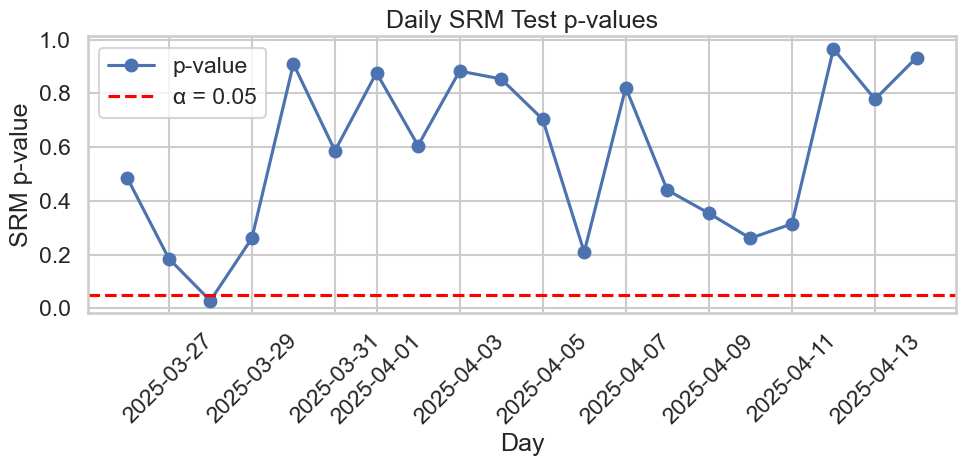

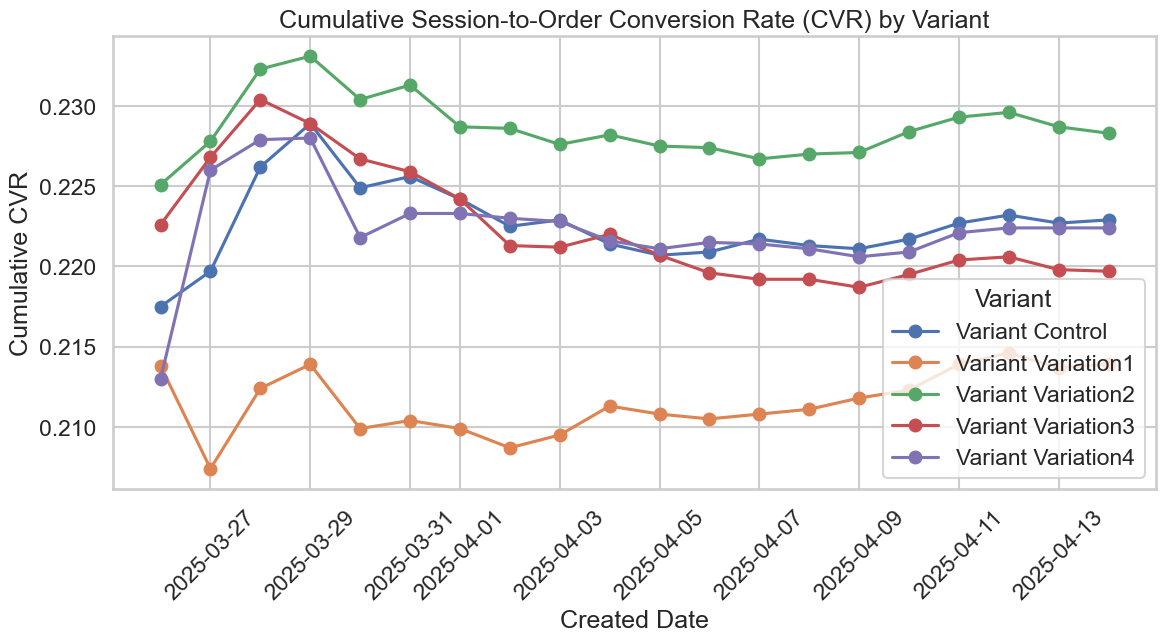

In [469]:
client = initialize_bigquery_client("logistics-customer-staging")

country_code = 'cy'
entity_id = 'FY_CY'
test_name = 'CY_20250324_R_A_O_elasticity'
test_id = 42
days_lagged = 1
split_created_at_start = '2025-03-25'
split_created_at_end = '2025-04-15'

test_df = client.query(test_data(split_created_at_start, split_created_at_end, days_lagged, test_id, entity_id, country_code)).to_dataframe()

## Data Quality checks ##

# null checks
check_null(test_df)

## check duplicates ##
session_col = 'session_id'

#get_unique_varying_columns(test_df, session_col)
#get_varying_columns_per_session(test_df, session_col)

## Check SRM for each day ##

daily_session_data = (
    test_df
    .groupby(['created_date', 'variant'])
    .agg({'session_id': 'nunique'})
    .rename(columns={'session_id': 'session_count'})
    .reset_index()
)
daily_session_data

srm_table = detect_srm(daily_session_data, day_col='created_date', variant_col='variant', count_col='session_count', alpha=0.05)

print(srm_table)

plot_srm_pvalues(srm_table, day_col='created_date')


## Cummulative conversion ##
daily_cvr_data = plot_cumulative_cvr_by_variant(test_df)

In [453]:
# Create aggregated data
agg_data = test_df.groupby(['session_id', 'variant', 'configured_df']).agg({
    'transaction_id': 'nunique'
}).reset_index()
# Compute summary per variant
summary_df = agg_data.groupby('variant').agg(
    sessions=('session_id', 'nunique'),
    conversions=('transaction_id', lambda x: (x > 0).sum())  # count of sessions with a transaction
).reset_index()

summary_df['conversion_rate'] = summary_df['conversions'] / summary_df['sessions']

# Extract control values
control_row = summary_df[summary_df['variant'] == 'Control'].iloc[0]
n1 = control_row['sessions']
x1 = control_row['conversions']
p1 = x1 / n1

# Z-test + CI function
def z_test_with_ci(n1, x1, n2, x2, confidence=0.95):
    p1 = x1 / n1
    p2 = x2 / n2
    p_pool = (x1 + x2) / (n1 + n2)
    SE = np.sqrt(p_pool * (1 - p_pool) * (1/n1 + 1/n2))
    z = (p2 - p1) / SE
    p_value = 2 * (1 - norm.cdf(abs(z)))

    # Effect size CI
    SE_diff = np.sqrt(p1 * (1 - p1) / n1 + p2 * (1 - p2) / n2)
    z_crit = norm.ppf(1 - (1 - confidence) / 2)
    ci_lower = (p2 - p1) - z_crit * SE_diff
    ci_upper = (p2 - p1) + z_crit * SE_diff

    return z, p_value, (ci_lower, ci_upper)

# Compare each variant to control
results = []
for _, row in summary_df.iterrows():
    if row['variant'] == 'Control':
        continue
    n2 = row['sessions']
    x2 = row['conversions']
    p2 = x2 / n2
    z, p_val, (ci_lower, ci_upper) = z_test_with_ci(n1, x1, n2, x2)
    effect_size = p2 - p1
    results.append({
        'variant': row['variant'],
        'control_rate': round(p1, 5),
        'variant_rate': round(p2, 5),
        'effect_size': round(effect_size, 5),
        'ci_lower': round(ci_lower, 5),
        'ci_upper': round(ci_upper, 5),
        'z_score': round(z, 4),
        'p_value': round(p_val, 4),
        'significant_5%': p_val < 0.05
    })


# Extract p-values from your results
pvals = [row['p_value'] for row in results]

# Apply Benjamini-Hochberg FDR correction
_, corrected_pvals, _, _ = multipletests(pvals, method='fdr_bh')

# Add corrected p-values to the results
for i, corrected_p in enumerate(corrected_pvals):
    results[i]['p_value_corrected'] = round(corrected_p, 4)
    results[i]['significant_5%_corrected'] = corrected_p < 0.05

# Display corrected results
results_df = pd.DataFrame(results)
print(results_df)

      variant  control_rate  variant_rate  effect_size  ci_lower  ci_upper  \
0  Variation1       0.22294       0.21386     -0.00907  -0.01374  -0.00440   
1  Variation2       0.22294       0.22831      0.00537   0.00064   0.01009   
2  Variation3       0.22294       0.21974     -0.00320  -0.00789   0.00150   
3  Variation4       0.22294       0.22236     -0.00058  -0.00528   0.00413   

   z_score  p_value  significant_5%  p_value_corrected  \
0  -3.8079   0.0001            True             0.0004   
1   2.2274   0.0259            True             0.0518   
2  -1.3332   0.1825           False             0.2433   
3  -0.2397   0.8106           False             0.8106   

   significant_5%_corrected  
0                      True  
1                     False  
2                     False  
3                     False  


In [454]:
test_df.columns

Index(['dh_platform', 'entity_id', 'country_code', 'created_at',
       'created_date', 'session_id', 'perseus_client_id', 'customer_id',
       'customer_location', 'id', 'variant', 'vertical_parent',
       'total_transactions', 'transaction_id', 'configured_df',
       'delivery_fee_eur', 'dps_delivery_fee_eur', 'profit_eur',
       'travel_time_distance_km', 'travel_time', 'platform_order_code',
       'gfv_eur', 'gmv_eur', 'delivery_costs_eur',
       'fully_loaded_gross_profit_eur', 'has_subscription',
       'subscription_discount_type'],
      dtype='object')

In [455]:
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import multipletests

# Aggregate metrics at session level
session_metrics = test_df.groupby(['session_id', 'variant']).agg({
    'profit_eur': 'sum',
    'gmv_eur': 'sum',
    'fully_loaded_gross_profit_eur':'sum',
    'platform_order_code': 'nunique'  # count of unique orders per session
}).reset_index()

# Rename for easier access
session_metrics = session_metrics.rename(columns={
    'profit_eur': 'profit',
    'gmv_eur': 'gmv',
    'fully_loaded_gross_profit_eur':'flgp',
    'platform_order_code': 'orders'
})

# Ensure numeric and drop rows with missing values
session_metrics[['profit', 'gmv','flgp','orders']] = session_metrics[['profit', 'gmv','flgp','orders']].apply(pd.to_numeric, errors='coerce')
session_metrics = session_metrics.dropna(subset=['profit', 'gmv','flgp','orders'])

# Run t-tests
control_sessions = session_metrics[session_metrics['variant'] == 'Control']
results = []

for variant in session_metrics['variant'].unique():
    if variant == 'Control':
        continue
    treatment_sessions = session_metrics[session_metrics['variant'] == variant]

    for metric in ['profit', 'gmv','flgp','orders']:
        t_stat, p_val = ttest_ind(
            treatment_sessions[metric], 
            control_sessions[metric], 
            equal_var=False  # Welch's t-test
        )
        results.append({
            'variant': variant,
            'metric': metric,
            'control_mean': round(control_sessions[metric].mean(), 5),
            'variant_mean': round(treatment_sessions[metric].mean(), 5),
            'effect_size': round(treatment_sessions[metric].mean() - control_sessions[metric].mean(), 5),
            't_stat': round(t_stat, 4),
            'p_value': round(p_val, 4),
            'significant_5%': p_val < 0.05
        })

# Multiple testing correction
pvals = [r['p_value'] for r in results]
_, corrected_pvals, _, _ = multipletests(pvals, method='fdr_bh')
for i, corrected_p in enumerate(corrected_pvals):
    results[i]['p_value_corrected'] = round(corrected_p, 4)
    results[i]['significant_5%_corrected'] = corrected_p < 0.05


# Results DataFrame
results_df = pd.DataFrame(results)
results_df = results_df.sort_values(by=['metric','variant']).reset_index(drop=True)

results_df

,variant,metric,control_mean,variant_mean,effect_size,t_stat,p_value,significant_5%,p_value_corrected,significant_5%_corrected
0,Variation1,flgp,0.27922,0.32462,0.04540,3.4663,0.0005,True,0.0043,True
1,Variation2,flgp,0.27922,0.24558,-0.03365,-2.6164,0.0089,True,0.0346,True
2,Variation3,flgp,0.27922,0.28929,0.01007,0.7494,0.4536,False,0.6216,False
3,Variation4,flgp,0.27922,0.26328,-0.01595,-1.1974,0.2311,False,0.4108,False
4,Variation1,gmv,4.68038,4.59343,-0.08695,-1.2898,0.1971,False,0.3942,False
5,Variation2,gmv,4.68038,4.70535,0.02497,0.3731,0.7091,False,0.7564,False
6,Variation3,gmv,4.68038,4.64036,-0.04002,-0.5957,0.5514,False,0.6786,False
7,Variation4,gmv,4.68038,4.64480,-0.03559,-0.5267,0.5984,False,0.6839,False
8,Variation1,orders,0.21925,0.21110,-0.00815,-3.3900,0.0007,True,0.0043,True
9,Variation2,orders,0.21925,0.22446,0.00521,2.1452,0.0319,True,0.0851,False


/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_36262/1129733477.py:10: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  g = sns.catplot(


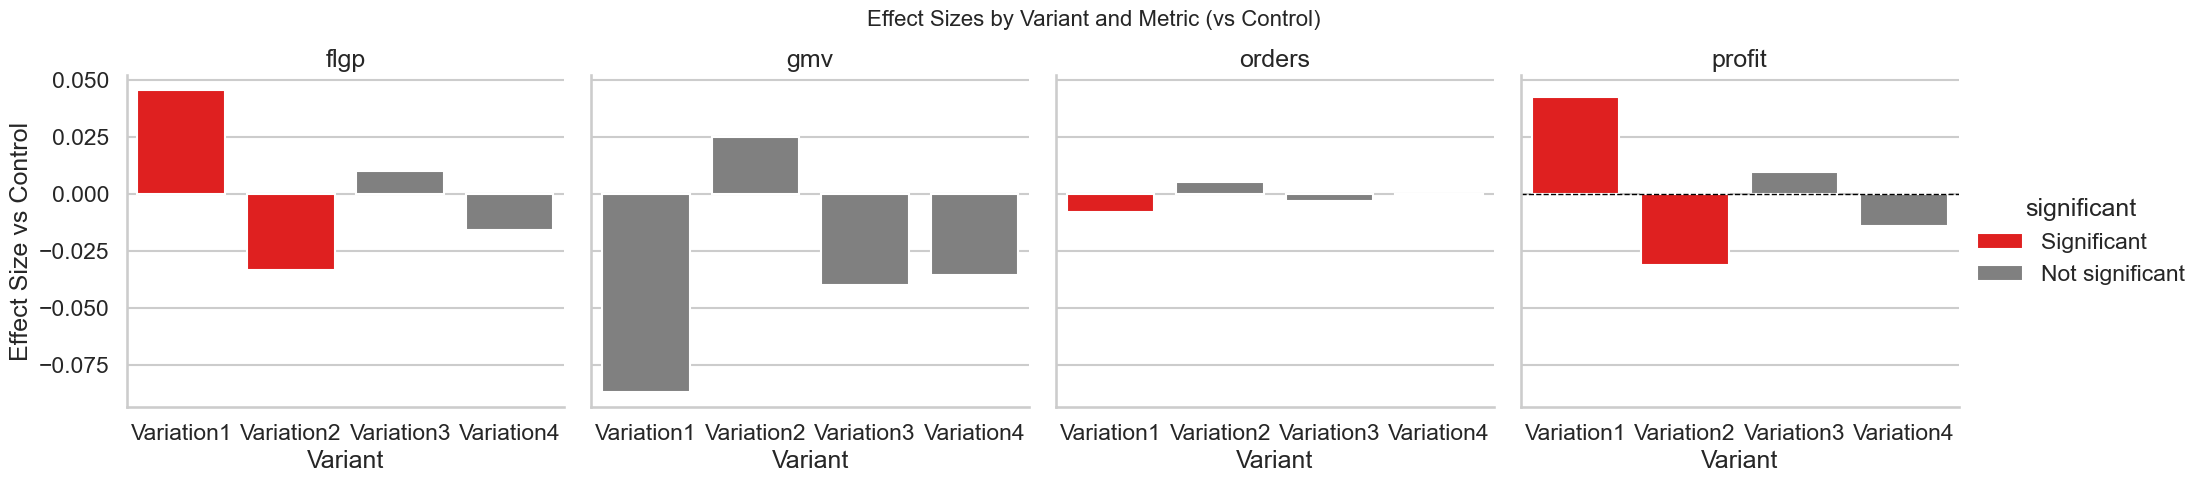

In [456]:
import seaborn as sns
import matplotlib.pyplot as plt

# Prep data
plot_df = results_df.copy()
plot_df['significant'] = plot_df['significant_5%_corrected'].map({True: 'Significant', False: 'Not significant'})

# Set up the plot
sns.set(style="whitegrid", context="talk")
g = sns.catplot(
    data=plot_df, kind="bar",
    x="variant", y="effect_size", hue="significant",
    col="metric", ci=None, palette={"Significant": "red", "Not significant": "gray"},
    height=5, aspect=1
)

g.set_titles("{col_name}")
g.set_axis_labels("Variant", "Effect Size vs Control")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle("Effect Sizes by Variant and Metric (vs Control)", fontsize=16)

plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.show()


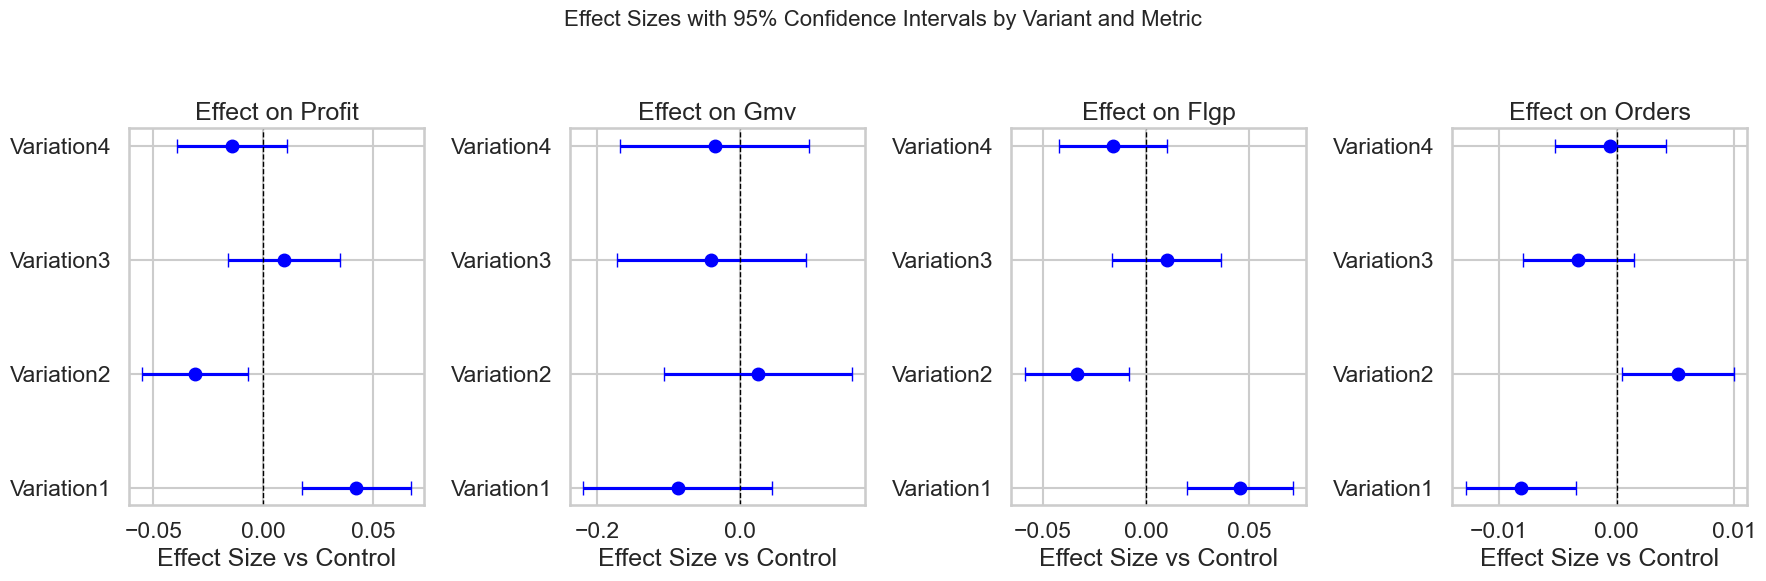

In [457]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import t
import numpy as np
import pandas as pd

# Compute Welch confidence intervals
ci_results = []

for variant in session_metrics['variant'].unique():
    if variant == 'Control':
        continue
    treatment_sessions = session_metrics[session_metrics['variant'] == variant]

    for metric in ['profit', 'gmv','flgp','orders']:
        x1 = control_sessions[metric].values
        x2 = treatment_sessions[metric].values

        mean1 = np.mean(x1)
        mean2 = np.mean(x2)
        diff = mean2 - mean1

        s1_sq = np.var(x1, ddof=1)
        s2_sq = np.var(x2, ddof=1)
        n1 = len(x1)
        n2 = len(x2)

        se = np.sqrt(s1_sq / n1 + s2_sq / n2)
        df = (s1_sq/n1 + s2_sq/n2)**2 / ((s1_sq**2)/((n1**2)*(n1-1)) + (s2_sq**2)/((n2**2)*(n2-1)))
        t_crit = t.ppf(0.975, df)

        ci_lower = diff - t_crit * se
        ci_upper = diff + t_crit * se

        ci_results.append({
            'variant': variant,
            'metric': metric,
            'effect_size': diff,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper
        })

ci_df = pd.DataFrame(ci_results)

# Sort for better layout
ci_df = ci_df.sort_values(by=['metric', 'variant'])

# Plot
sns.set(style="whitegrid", context="talk")
fig, axes = plt.subplots(1, 4, figsize=(18, 6), sharex=False)

for i, metric in enumerate(['profit', 'gmv','flgp','orders']):
    ax = axes[i]
    subset = ci_df[ci_df['metric'] == metric]
    ax.errorbar(
        x=subset['effect_size'],
        y=subset['variant'],
        xerr=[
            subset['effect_size'] - subset['ci_lower'],
            subset['ci_upper'] - subset['effect_size']
        ],
        fmt='o',
        capsize=5,
        color='blue'
    )
    ax.axvline(x=0, linestyle='--', color='black', linewidth=1)
    ax.set_title(f'Effect on {metric.capitalize()}')
    ax.set_xlabel('Effect Size vs Control')
    ax.set_ylabel('')

plt.suptitle('Effect Sizes with 95% Confidence Intervals by Variant and Metric', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


In [458]:
## Summary Statistics ###

#tmp = test_df[~test_df['platform_order_code'].isnull()]

# tmp = test_df[~test_df.duplicated()].copy()

tmp = test_df.copy()

# Grouped summary
agg = tmp.groupby(['variant','configured_df']).agg({
    'platform_order_code': 'nunique',
    'session_id' : 'nunique',
    'gmv_eur': 'sum',
    'delivery_costs_eur': 'sum',
    'fully_loaded_gross_profit_eur': 'sum',
    'profit_eur':'sum',
    'gfv_eur': 'sum',
    'travel_time_distance_km':'mean'
}).rename(columns={'platform_order_code': 'num_orders'}).reset_index()

# Compute per-order metrics
agg['session_to_order_conversion'] = agg['num_orders'] / agg['session_id']
agg['gmv_per_order'] = agg['gmv_eur'] / agg['num_orders']
agg['delivery_costs_per_order'] = agg['delivery_costs_eur'] / agg['num_orders']
agg['gross_profit_per_order'] = agg['fully_loaded_gross_profit_eur'] / agg['num_orders']
agg['gfv_per_order'] = agg['gfv_eur'] / agg['num_orders']

# Round specified columns in-place
cols_to_round = [
    'gmv_eur', 'delivery_costs_eur', 'fully_loaded_gross_profit_eur',
    'profit_eur', 'gfv_eur', 'travel_time_distance_km', 'gmv_per_order',
    'delivery_costs_per_order', 'gross_profit_per_order', 'gfv_per_order'
]

cols_to_float = [
    'session_to_order_conversion', 'profit_eur', 'num_orders',
    'gmv_per_order', 'delivery_costs_per_order', 'gross_profit_per_order'
]

agg[cols_to_float] = agg[cols_to_float].astype(float)

agg[cols_to_round] = agg[cols_to_round].round(2)

# Get session count in control group
control_sessions = agg.loc[agg["variant"] == "Control", "session_id"].values[0]

# Normalize num_orders to control's session volume
agg["normalized_num_orders"] = agg["session_to_order_conversion"] * control_sessions

# Optional: Add relative lift vs control (normalized)
control_orders = agg.loc[agg["variant"] == "Control", "normalized_num_orders"].values[0]
agg["normalized_order_lift_vs_control"] = (agg["normalized_num_orders"] - control_orders) / control_orders

agg["normalized_profit_eur"] = agg["session_to_order_conversion"] * agg["profit_eur"] / agg["num_orders"] * control_sessions
agg["normalized_gmv_eur"] = agg["session_to_order_conversion"] * agg["gmv_per_order"] * control_sessions
agg["normalized_delivery_costs_eur"] = agg["session_to_order_conversion"] * agg["delivery_costs_per_order"] * control_sessions
agg["normalized_gross_profit_eur"] = agg["session_to_order_conversion"] * agg["gross_profit_per_order"] * control_sessions

agg.style.format({
    'configured_df': '{:,.2f}',
    'gmv_eur': '{:,.2f}',
    'delivery_costs_eur': '{:,.2f}',
    'fully_loaded_gross_profit_eur': '{:,.2f}',
    'profit_eur': '{:,.2f}',
    'gfv_eur': '{:,.2f}',
    'travel_time_distance_km': '{:.2f}',
    'gmv_per_order': '{:.2f}',
    'delivery_costs_per_order': '{:.2f}',
    'gross_profit_per_order': '{:.2f}',
    'gfv_per_order': '{:.2f}',
})


,variant,configured_df,num_orders,session_id,gmv_eur,delivery_costs_eur,fully_loaded_gross_profit_eur,profit_eur,gfv_eur,travel_time_distance_km,session_to_order_conversion,gmv_per_order,delivery_costs_per_order,gross_profit_per_order,gfv_per_order,normalized_num_orders,normalized_order_lift_vs_control,normalized_profit_eur,normalized_gmv_eur,normalized_delivery_costs_eur,normalized_gross_profit_eur
0,Control,1.89,13192.000000,60169,"281,614.02","54,800.70","16,800.56","21,205.38","265,707.20",2.70,0.219249,21.35,4.15,1.27,20.14,13192.000000,0.000000,21205.380000,281649.200000,54746.800000,16753.840000
1,Variation1,2.09,12683.000000,60080,"275,973.37","52,277.09","19,503.37","23,711.88","256,554.54",2.66,0.211102,21.76,4.12,1.54,20.23,12701.788066,-0.037160,23747.005788,276390.908314,52331.366832,19560.753622
2,Variation2,1.69,13486.000000,60081,"282,702.08","55,811.06","14,754.41","19,305.73","268,414.95",2.69,0.224464,20.96,4.14,1.09,19.90,13505.752800,0.023784,19334.006897,283080.578696,55913.816594,14721.270552
3,Variation3,1.99,12925.000000,59838,"277,669.88","54,043.52","17,310.66","21,652.35","259,836.27",2.66,0.216000,21.48,4.18,1.34,20.10,12996.495956,-0.014820,21772.122182,279164.733129,54325.353095,17415.304581
4,Variation4,1.79,13100.000000,59893,"278,190.80","54,408.87","15,768.49","20,254.22","263,654.96",2.69,0.218723,21.24,4.15,1.20,20.13,13160.367656,-0.002398,20347.555861,279526.209006,54615.525771,15792.441187


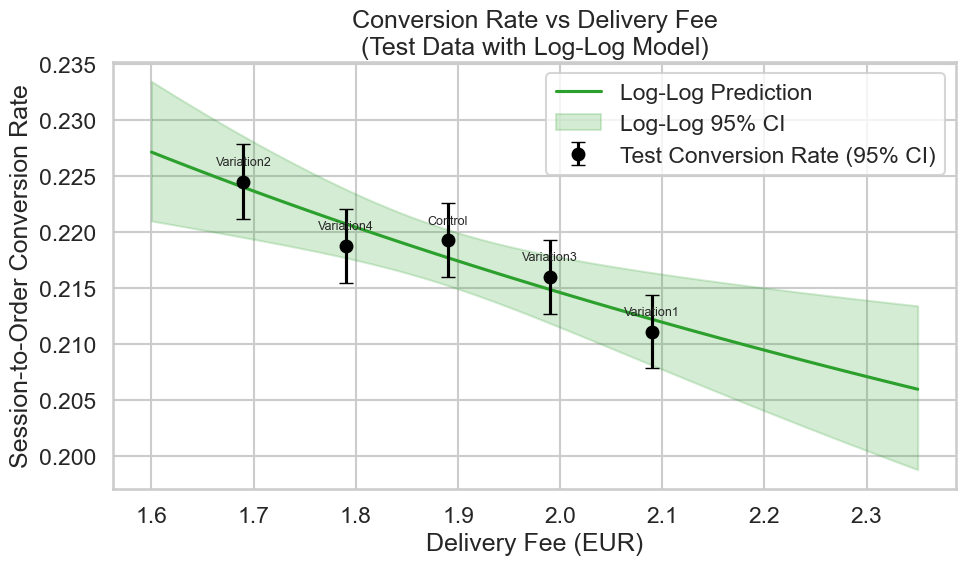

In [459]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import norm

summary_df = agg.copy()

summary_df["conversion_rate"] = summary_df["num_orders"] / summary_df["session_id"]

# Step 2: Compute standard error and confidence intervals
z = norm.ppf(0.975)
summary_df["se"] = np.sqrt(summary_df["conversion_rate"] * (1 - summary_df["conversion_rate"]) / summary_df["session_id"])
summary_df["ci_lower"] = summary_df["conversion_rate"] - z * summary_df["se"]
summary_df["ci_upper"] = summary_df["conversion_rate"] + z * summary_df["se"]

# Step 3: Fit log-log model
summary_df["log_fee"] = np.log(summary_df["configured_df"])
summary_df["log_conv"] = np.log(summary_df["conversion_rate"])
X = sm.add_constant(summary_df["log_fee"])
y = summary_df["log_conv"]
model = sm.OLS(y, X).fit()

# Step 4: Predict over range
fees = np.linspace(1.60, 2.35, 100)
log_fees = np.log(fees)
X_new = sm.add_constant(log_fees)
preds = model.get_prediction(X_new)
summary_frame = preds.summary_frame(alpha=0.05)

conv_pred = np.exp(summary_frame["mean"].values)
conv_lower = np.exp(summary_frame["mean_ci_lower"].values)
conv_upper = np.exp(summary_frame["mean_ci_upper"].values)

# Step 5: Plot everything
plt.figure(figsize=(10, 6))

# Plot test points with error bars
plt.errorbar(summary_df["configured_df"], summary_df["conversion_rate"],
             yerr=z * summary_df["se"], fmt='o', color='black',
             capsize=5, label='Test Conversion Rate (95% CI)', zorder=3)

# Optional: Add variant name labels
for _, row in summary_df.iterrows():
    plt.text(row["configured_df"], row["conversion_rate"] + 0.0015, row["variant"],
             ha='center', fontsize=9, zorder=4)

# Plot model fit and confidence band
plt.plot(fees, conv_pred, label="Log-Log Prediction", color="tab:green", zorder=2)
plt.fill_between(fees, conv_lower, conv_upper, color="tab:green", alpha=0.2,
                 label="Log-Log 95% CI", zorder=1)

# Final styling
plt.xlabel("Delivery Fee (EUR)")
plt.ylabel("Session-to-Order Conversion Rate")
plt.title("Conversion Rate vs Delivery Fee\n(Test Data with Log-Log Model)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [416]:
import numpy as np
import statsmodels.api as sm

# Filter to valid sessions
df = test_df.copy()
df = df[(df["configured_df"] > 0)]

# Define binary outcome and log fee
df["converted"] = df["converted"].astype(int)
df["log_fee"] = np.log(df["configured_df"])

# Logistic regression: P(converted = 1) ~ log_fee
X = sm.add_constant(df["log_fee"])
y = df["converted"]

logit_model = sm.Logit(y, X).fit()
print(logit_model.summary())

# Elasticity (approximate marginal effect of log_fee on log-odds)
logit_elasticity = logit_model.params["log_fee"]


Optimization terminated successfully.
         Current function value: 0.529016
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:              converted   No. Observations:               321029
Model:                          Logit   Df Residuals:                   321027
Method:                           MLE   Df Model:                            1
Date:                Sun, 04 May 2025   Pseudo R-squ.:               9.429e-05
Time:                        21:36:49   Log-Likelihood:            -1.6983e+05
converged:                       True   LL-Null:                   -1.6985e+05
Covariance Type:            nonrobust   LLR p-value:                 1.518e-08
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0531      0.036    -29.230      0.000      -1.124      -0.982
log_fee       -0.3200      0.

In [411]:
# Ensure it's a datetime column
test_df['created_at'] = pd.to_datetime(test_df['created_at'])

# Extract hour and day of week
test_df['hour'] = test_df['created_at'].dt.hour
test_df['day_of_week'] = test_df['created_at'].dt.day_name()

grouped_df = test_df.groupby(['configured_df', 'day_of_week', 'hour']).agg(
    sessions=('session_id', 'nunique'),
    conversions=('converted', 'sum')
).reset_index()

grouped_df['conversion_rate'] = grouped_df['conversions'] / grouped_df['sessions']


grouped_df = grouped_df[grouped_df['configured_df'] > 0]
grouped_df = grouped_df[grouped_df['conversion_rate'] > 0]
grouped_df['log_fee'] = np.log(grouped_df['configured_df'])
grouped_df['log_conv'] = np.log(grouped_df['conversion_rate'])


results = []
for (dow, hour), df_sub in grouped_df.groupby(['day_of_week', 'hour']):
    if len(df_sub) < 3:
        continue
    X = sm.add_constant(df_sub['log_fee'])
    y = df_sub['log_conv']
    model = sm.OLS(y, X).fit()
    elasticity = model.params['log_fee']
    results.append({
        'day_of_week': dow,
        'hour': hour,
        'elasticity': elasticity,
        'p_value': model.pvalues['log_fee'],
        'n': len(df_sub)
    })

elasticity_by_segment = pd.DataFrame(results)


elasticity_by_segment[elasticity_by_segment['p_value'] < 0.05]

,day_of_week,hour,elasticity,p_value,n
24,Monday,7,-1.043152,0.002263,5
52,Saturday,16,0.931502,0.038156,5
66,Sunday,9,-0.819564,0.005378,5
72,Sunday,15,-0.437304,0.030255,5
75,Sunday,18,-0.725343,0.023645,5
92,Thursday,15,-1.134071,0.038795,5
94,Thursday,17,-0.824701,0.006622,5
113,Tuesday,16,-0.703091,0.047105,5


In [399]:
import patsy

# Treat DOW and hour as categorical
grouped_df['dow'] = grouped_df['day_of_week'].astype(str)
grouped_df['hr'] = grouped_df['hour'].astype(str)

# Interaction model with formula
y, X = patsy.dmatrices('log_conv ~ log_fee * dow * hr', data=grouped_df, return_type='dataframe')
model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:               log_conv   R-squared:                       0.929
Model:                            OLS   Adj. R-squared:                  0.879
Method:                 Least Squares   F-statistic:                     18.62
Date:                Sun, 04 May 2025   Prob (F-statistic):          1.44e-140
Time:                        21:15:24   Log-Likelihood:                 448.00
No. Observations:                 704   AIC:                            -312.0
Df Residuals:                     412   BIC:                             1019.
Df Model:                         291                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

In [409]:
y, X = patsy.dmatrices('log_conv ~ log_fee * dow', data=grouped_df, return_type='dataframe')
model = sm.OLS(y, X).fit()

# Extract base elasticity
base_elasticity = model.params['log_fee']

# Loop through dow levels to get each elasticity
elasticities = []
for dow in grouped_df['dow'].unique():
    col = f'log_fee:dow[{dow}]'
    if col in model.params:
        elasticity = base_elasticity + model.params[col]
        std_err = np.sqrt(model.cov_params().loc['log_fee', 'log_fee'] + 
                          model.cov_params().loc[col, col] +
                          2 * model.cov_params().loc['log_fee', col])
    else:
        elasticity = base_elasticity
        std_err = model.bse['log_fee']
        
    elasticities.append({
        'dow': dow,
        'elasticity': elasticity,
        'lower': elasticity - 1.96 * std_err,
        'upper': elasticity + 1.96 * std_err
    })

elasticity_df = pd.DataFrame(elasticities).sort_values('dow')


plt.figure(figsize=(10, 5))
plt.errorbar(elasticity_df['dow'], elasticity_df['elasticity'],
             yerr=[elasticity_df['elasticity'] - elasticity_df['lower'],
                   elasticity_df['upper'] - elasticity_df['elasticity']],
             fmt='o', capsize=5, color='mediumblue')
plt.axhline(0, color='gray', linestyle='--')
plt.title("Estimated Elasticity by Day of Week (from Interaction Model)")
plt.ylabel("Elasticity (log_fee effect on log_conv)")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()



PatsyError: Number of rows mismatch between data argument and dow (35 versus 1)
    log_conv ~ log_fee * dow
                         ^^^

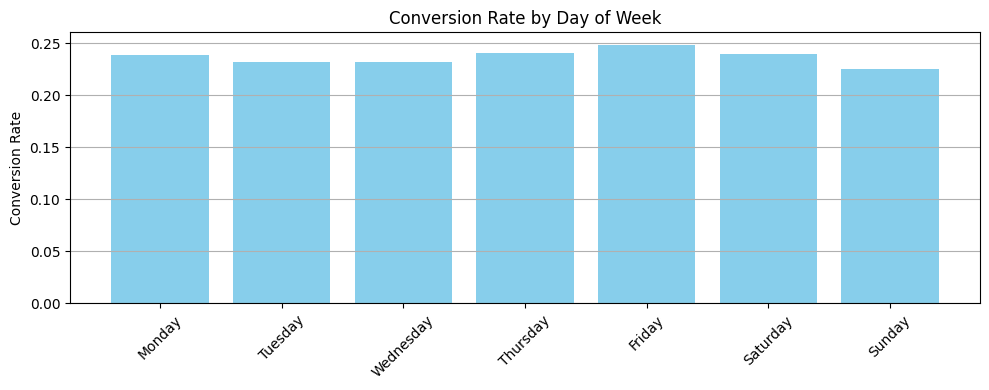

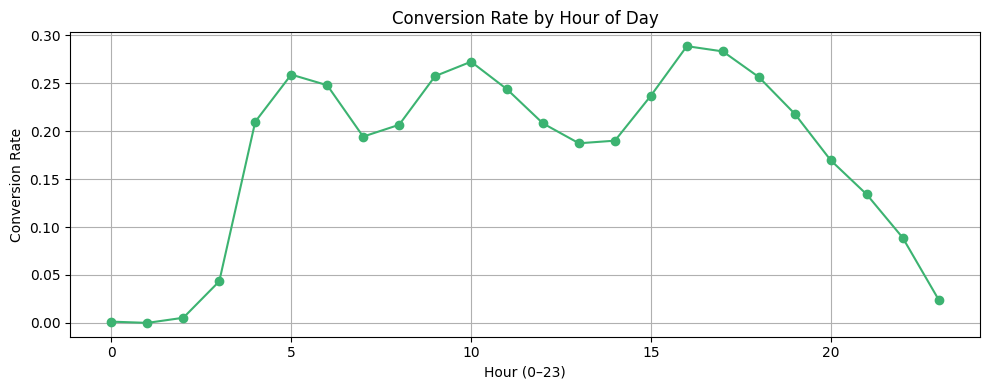

In [402]:
# Group by day of week
dow_summary = test_df.groupby("day_of_week").agg(
    sessions=("session_id", "nunique"),
    conversions=("converted", "sum")
).reset_index()
dow_summary["conversion_rate"] = dow_summary["conversions"] / dow_summary["sessions"]

# Group by hour of day
hour_summary = test_df.groupby("hour").agg(
    sessions=("session_id", "nunique"),
    conversions=("converted", "sum")
).reset_index()
hour_summary["conversion_rate"] = hour_summary["conversions"] / hour_summary["sessions"]

import matplotlib.pyplot as plt

# Day of Week Plot
plt.figure(figsize=(10, 4))
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
dow_summary = dow_summary.set_index("day_of_week").loc[ordered_days].reset_index()
plt.bar(dow_summary["day_of_week"], dow_summary["conversion_rate"], color="skyblue")
plt.title("Conversion Rate by Day of Week")
plt.ylabel("Conversion Rate")
plt.xticks(rotation=45)
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

# Hour of Day Plot
plt.figure(figsize=(10, 4))
plt.plot(hour_summary["hour"], hour_summary["conversion_rate"], marker="o", color="mediumseagreen")
plt.title("Conversion Rate by Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Conversion Rate")
plt.grid(True)
plt.tight_layout()
plt.show()

from scipy.stats import norm

z = norm.ppf(0.975)
dow_summary["se"] = np.sqrt(dow_summary["conversion_rate"] * (1 - dow_summary["conversion_rate"]) / dow_summary["sessions"])
dow_summary["ci_lower"] = dow_summary["conversion_rate"] - z * dow_summary["se"]
dow_summary["ci_upper"] = dow_summary["conversion_rate"] + z * dow_summary["se"]



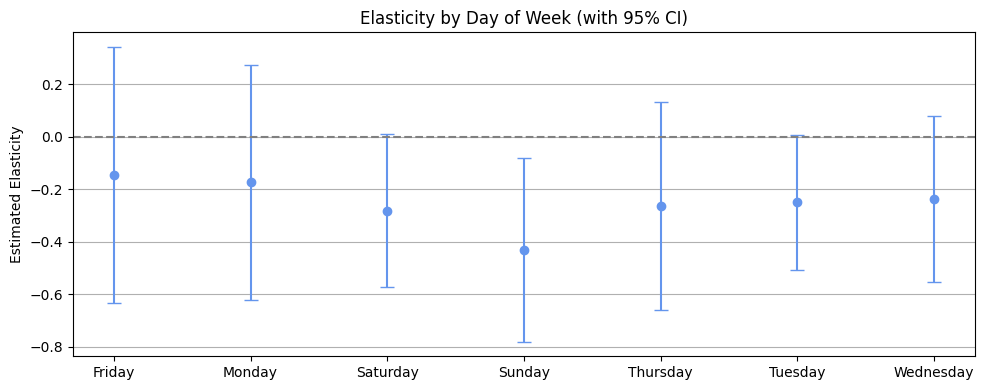

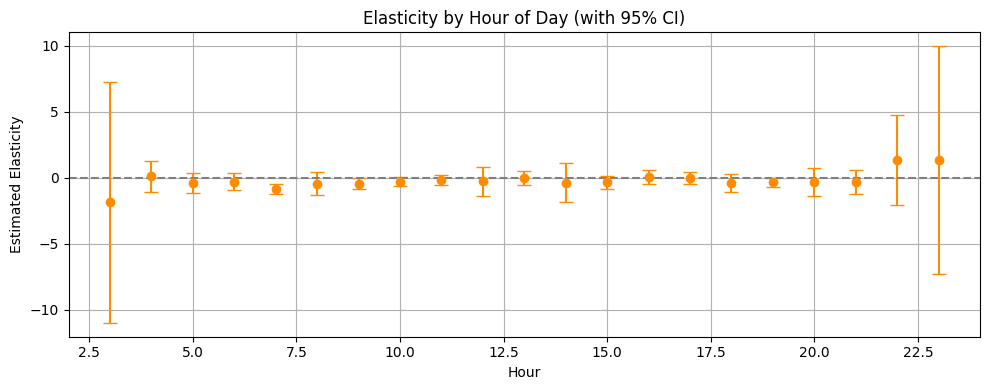

In [406]:
# Aggregated by fee, day, or hour
grouped_df = test_df.groupby(["configured_df", "day_of_week"]).agg(
    conversions=("converted", "sum"),
    sessions=("session_id", "nunique")
).reset_index()
grouped_df["conversion_rate"] = grouped_df["conversions"] / grouped_df["sessions"]


grouped_df = grouped_df[(grouped_df["configured_df"] > 0) & (grouped_df["conversion_rate"] > 0)]
grouped_df["log_fee"] = np.log(grouped_df["configured_df"])
grouped_df["log_conv"] = np.log(grouped_df["conversion_rate"])


results = []

for day, df_sub in grouped_df.groupby("day_of_week"):
    if len(df_sub) < 3:
        continue
    X = sm.add_constant(df_sub["log_fee"])
    y = df_sub["log_conv"]
    model = sm.OLS(y, X).fit()
    elasticity = model.params["log_fee"]
    ci_low, ci_up = model.conf_int().loc["log_fee"]
    results.append({
        "day_of_week": day,
        "elasticity": elasticity,
        "ci_lower": ci_low,
        "ci_upper": ci_up,
        "p_value": model.pvalues["log_fee"],
        "n_points": len(df_sub)
    })

elasticity_by_dow = pd.DataFrame(results).sort_values("day_of_week")



results = []

for hour, df_sub in test_df.groupby("hour"):
    agg = df_sub.groupby("configured_df").agg(
        sessions=("session_id", "nunique"),
        conversions=("converted", "sum")
    ).reset_index()
    agg["conversion_rate"] = agg["conversions"] / agg["sessions"]
    agg = agg[(agg["configured_df"] > 0) & (agg["conversion_rate"] > 0)]
    if len(agg) < 3:
        continue
    agg["log_fee"] = np.log(agg["configured_df"])
    agg["log_conv"] = np.log(agg["conversion_rate"])
    X = sm.add_constant(agg["log_fee"])
    y = agg["log_conv"]
    model = sm.OLS(y, X).fit()
    elasticity = model.params["log_fee"]
    ci_low, ci_up = model.conf_int().loc["log_fee"]
    results.append({
        "hour": hour,
        "elasticity": elasticity,
        "ci_lower": ci_low,
        "ci_upper": ci_up,
        "p_value": model.pvalues["log_fee"],
        "n_points": len(agg)
    })

elasticity_by_hour = pd.DataFrame(results).sort_values("hour")



plt.figure(figsize=(10, 4))
plt.errorbar(elasticity_by_dow["day_of_week"],
             elasticity_by_dow["elasticity"],
             yerr=[elasticity_by_dow["elasticity"] - elasticity_by_dow["ci_lower"],
                   elasticity_by_dow["ci_upper"] - elasticity_by_dow["elasticity"]],
             fmt='o', color='cornflowerblue', capsize=5)
plt.title("Elasticity by Day of Week (with 95% CI)")
plt.ylabel("Estimated Elasticity")
plt.axhline(0, color="gray", linestyle="--")
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()


# Hour of day
plt.figure(figsize=(10, 4))
plt.errorbar(elasticity_by_hour["hour"],
             elasticity_by_hour["elasticity"],
             yerr=[elasticity_by_hour["elasticity"] - elasticity_by_hour["ci_lower"],
                   elasticity_by_hour["ci_upper"] - elasticity_by_hour["elasticity"]],
             fmt='o', color='darkorange', capsize=5)
plt.title("Elasticity by Hour of Day (with 95% CI)")
plt.xlabel("Hour")
plt.ylabel("Estimated Elasticity")
plt.axhline(0, color="gray", linestyle="--")
plt.grid(True)
plt.tight_layout()
plt.show()



In [412]:
from statsmodels.regression.mixed_linear_model import MixedLM

# Clean data
grouped_df = test_df.groupby(["configured_df", "day_of_week", "hour"]).agg(
    conversions=("converted", "sum"),
    sessions=("session_id", "nunique")
).reset_index()
grouped_df["conversion_rate"] = grouped_df["conversions"] / grouped_df["sessions"]

# Filter and log-transform
grouped_df = grouped_df[(grouped_df["conversion_rate"] > 0) & (grouped_df["configured_df"] > 0)]
grouped_df["log_fee"] = np.log(grouped_df["configured_df"])
grouped_df["log_conv"] = np.log(grouped_df["conversion_rate"])

# Optional: combine dow + hour into a segment
grouped_df["segment"] = grouped_df["day_of_week"].astype(str) + "_" + grouped_df["hour"].astype(str)


# Random intercepts + slopes for each segment
md = MixedLM.from_formula("log_conv ~ log_fee", 
                          groups=grouped_df["segment"],
                          re_formula="~log_fee",
                          data=grouped_df)
mixed_model = md.fit()
print(mixed_model.summary())


# Global elasticity (fixed effect)
global_elasticity = mixed_model.params["log_fee"]

# Per-group deviations from fixed slope
random_slopes = mixed_model.random_effects

segment_elasticities = []
for segment, effects in random_slopes.items():
    elasticity = global_elasticity + effects.get("log_fee", 0.0)
    segment_elasticities.append({
        "segment": segment,
        "elasticity": elasticity
    })

segment_elasticities_df = pd.DataFrame(segment_elasticities)




             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    log_conv
No. Observations:    704        Method:                REML    
No. Groups:          147        Scale:                 0.0324  
Min. group size:     1          Log-Likelihood:        -85.1397
Max. group size:     5          Converged:             Yes     
Mean group size:     4.8                                       
---------------------------------------------------------------
                    Coef.  Std.Err.    z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept           -1.529    0.080 -19.219 0.000 -1.685 -1.373
log_fee             -0.270    0.107  -2.514 0.012 -0.481 -0.060
Group Var            0.417    0.928                            
Group x log_fee Cov -0.264    1.132                            
log_fee Var          0.441    1.638                            



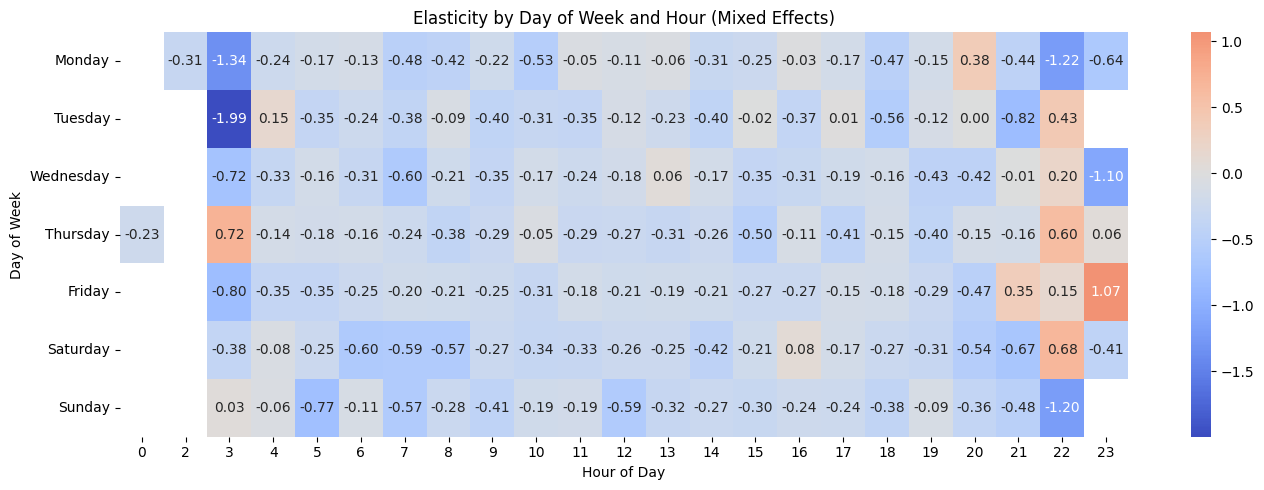

In [413]:
# Global elasticity
global_elasticity = mixed_model.params["log_fee"]

# Build segment-specific elasticity DataFrame
elasticities = []
for seg, re in mixed_model.random_effects.items():
    segment_elasticity = global_elasticity + re.get("log_fee", 0.0)
    dow, hr = seg.split("_")
    elasticities.append({
        "day_of_week": dow,
        "hour": int(hr),
        "elasticity": segment_elasticity
    })

elasticity_df = pd.DataFrame(elasticities)


pivot = elasticity_df.pivot(index="day_of_week", columns="hour", values="elasticity")
ordered_days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
pivot = pivot.reindex(ordered_days)

plt.figure(figsize=(14, 5))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="coolwarm", center=0)
plt.title("Elasticity by Day of Week and Hour (Mixed Effects)")
plt.xlabel("Hour of Day")
plt.ylabel("Day of Week")
plt.tight_layout()
plt.show()


                            OLS Regression Results                            
Dep. Variable:         log_conversion   R-squared:                       0.904
Model:                            OLS   Adj. R-squared:                  0.872
Method:                 Least Squares   F-statistic:                     28.29
Date:                Sun, 04 May 2025   Prob (F-statistic):             0.0130
Time:                        22:37:19   Log-Likelihood:                 18.309
No. Observations:                   5   AIC:                            -32.62
Df Residuals:                       3   BIC:                            -33.40
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3628      0.030    -44.694      0.0

/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "


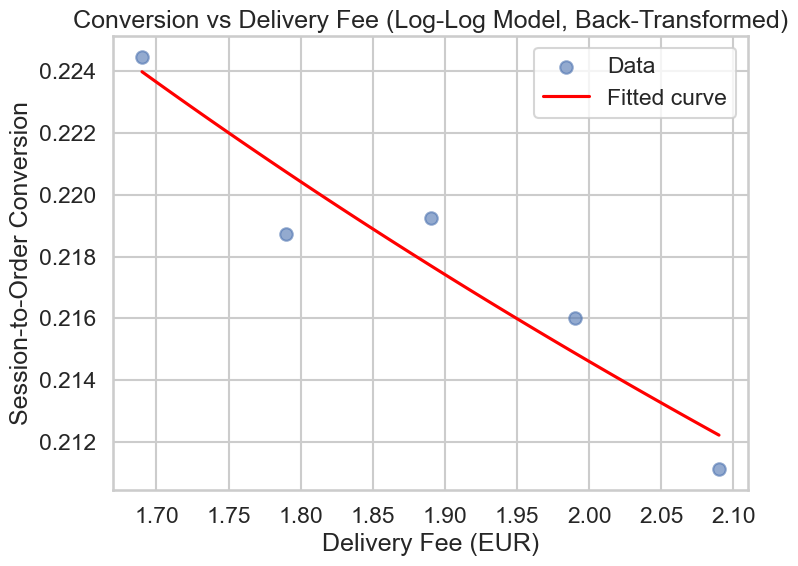

In [460]:
import numpy as np
import pandas as pd
import statsmodels.api as sm


df = agg.copy()

# Filter to positive values
mask = (df["configured_df"] > 0) & (df["session_to_order_conversion"] > 0)
df_filtered = df[mask].copy()

# Convert to float
df_filtered["delivery_fee_eur"] = df_filtered["configured_df"].astype(float)
df_filtered["session_to_order_conversion"] = df_filtered["session_to_order_conversion"].astype(float)

# Log-transform
df_filtered["log_fee"] = np.log(df_filtered["delivery_fee_eur"])
df_filtered["log_conversion"] = np.log(df_filtered["session_to_order_conversion"])

# Fit log-log linear model
X = sm.add_constant(df_filtered["log_fee"])
y = df_filtered["log_conversion"]
model = sm.OLS(y, X).fit()

# Output results
print(model.summary())

# Elasticity
elasticity = model.params["log_fee"]
print(f"\nEstimated price elasticity of demand: {elasticity:.3f}")


# Scatter plot in original scale
plt.figure(figsize=(8, 6))
plt.scatter(df_filtered["delivery_fee_eur"], df_filtered["session_to_order_conversion"],
            alpha=0.6, label="Data")

# Fitted curve from log-log model (back-transformed)
fee_vals = np.linspace(df_filtered["delivery_fee_eur"].min(), df_filtered["delivery_fee_eur"].max(), 100)
log_fee_vals = np.log(fee_vals)
log_conv_preds = model.predict(sm.add_constant(log_fee_vals))
conv_preds = np.exp(log_conv_preds)  # back-transform to original scale

plt.plot(fee_vals, conv_preds, color="red", label="Fitted curve")

# Labels and title
plt.xlabel("Delivery Fee (EUR)")
plt.ylabel("Session-to-Order Conversion")
plt.title("Conversion vs Delivery Fee (Log-Log Model, Back-Transformed)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

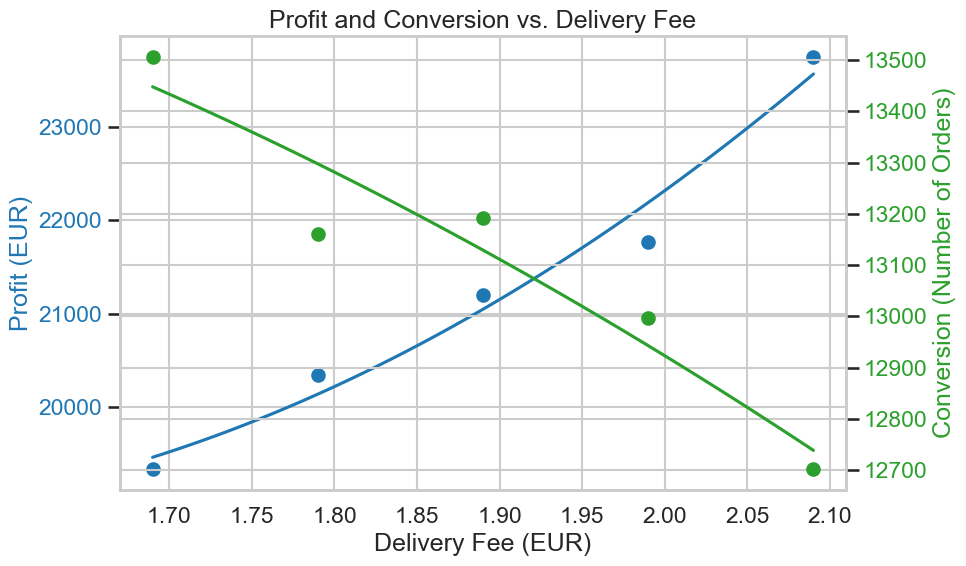

(np.float64(1.4502203896336026), np.float64(0.9039350875035235))

In [461]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define quadratic function for fitting
def quadratic(x, a, b, c):
    return a * x**2 + b * x + c

# Fit curves
x = df["configured_df"]
y_profit = df["normalized_profit_eur"]
y_conversion = df["normalized_num_orders"]

# Fit quadratic curves
params_profit, _ = curve_fit(quadratic, x, y_profit)
params_conv, _ = curve_fit(quadratic, x, y_conversion)

# Generate smooth x values
x_fit = np.linspace(min(x), max(x), 100)
y_profit_fit = quadratic(x_fit, *params_profit)
y_conv_fit = quadratic(x_fit, *params_conv)

# Plot both curves on the same figure with dual axes
fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Delivery Fee (EUR)')
ax1.set_ylabel('Profit (EUR)', color=color)
ax1.plot(x_fit, y_profit_fit, color=color, label='Profit Curve')
ax1.scatter(x, y_profit, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Conversion (Number of Orders)', color=color)
ax2.plot(x_fit, y_conv_fit, color=color, label='Conversion Curve')
ax2.scatter(x, y_conversion, color=color)
ax2.tick_params(axis='y', labelcolor=color)

plt.title("Profit and Conversion vs. Delivery Fee")
fig.tight_layout()
plt.show()
# Compute delivery fee that maximizes profit
a_p, b_p, _ = params_profit
max_profit_fee = -b_p / (2 * a_p)

# Compute delivery fee that maximizes conversion
a_c, b_c, _ = params_conv
max_conversion_fee = -b_c / (2 * a_c)

(max_profit_fee, max_conversion_fee)


In [462]:
from scipy.interpolate import interp1d

# Create interpolation function for profit using cubic interpolation
profit_interp_func = interp1d(x_smooth_profit, y_smooth_profit, kind='cubic', fill_value="extrapolate")

# Simulate profit for the same delivery fees
simulated_profits = profit_interp_func(simulated_fees)

# Bootstrap profit confidence intervals
boot_profits_clean = []
valid_boots = 0

while valid_boots < max_boots:
    sample_df = df.sample(frac=1.0, replace=True)
    x_sample = sample_df["configured_df"].values
    y_sample = sample_df["normalized_profit_eur"].values

    lowess_sample = sm.nonparametric.lowess(y_sample, x_sample, frac=0.8, return_sorted=True)
    x_s, y_s = lowess_sample[:, 0], lowess_sample[:, 1]

    # Drop duplicate x values
    x_unique, idx = np.unique(x_s, return_index=True)
    y_unique = y_s[idx]

    if len(x_unique) < 4 or np.allclose(y_unique, y_unique[0], atol=1e-6):
        continue

    try:
        interp_func = interp1d(x_unique, y_unique, kind='cubic', bounds_error=False, fill_value=np.nan)
        interpolated_profits = interp_func(simulated_fees)

        if np.any(np.isnan(interpolated_profits)):
            continue  # skip invalid extrapolations

        boot_profits_clean.append(interpolated_profits)
        valid_boots += 1
    except Exception:
        continue

# Convert to array for confidence interval calculation
boot_profits_array = np.array(boot_profits_clean)

# Compute confidence intervals for profit
profit_lower = np.percentile(boot_profits_array, 2.5, axis=0)
profit_upper = np.percentile(boot_profits_array, 97.5, axis=0)

# Prepare output DataFrame
profit_results = pd.DataFrame({
    "delivery_fee": simulated_fees,
    "predicted_profit": simulated_profits,
    "lower_ci": profit_lower,
    "upper_ci": profit_upper
})

print(profit_results)


/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


KeyboardInterrupt: 

In [463]:
# Create interpolation function for conversion using cubic interpolation
conversion_interp_func = interp1d(x_smooth_conv, y_smooth_conv, kind='cubic', fill_value="extrapolate")

# Simulate conversion for the same delivery fees
simulated_conversions = conversion_interp_func(simulated_fees)

# Bootstrap conversion confidence intervals
boot_conversions_clean = []
valid_boots = 0

while valid_boots < max_boots:
    sample_df = df.sample(frac=1.0, replace=True)
    x_sample = sample_df["configured_df"]
    y_sample = sample_df["normalized_num_orders"]
    lowess_sample = sm.nonparametric.lowess(y_sample, x_sample, frac=0.8, return_sorted=True)

    x_s, y_s = zip(*lowess_sample)
    x_unique, idx = np.unique(x_s, return_index=True)

    if len(x_unique) < 2:
        continue

    y_unique = np.array(y_s)[idx]
    interp_func = interp1d(x_unique, y_unique, kind='linear', fill_value="extrapolate")
    boot_conversions_clean.append(interp_func(simulated_fees))
    valid_boots += 1

boot_conversions_array = np.array(boot_conversions_clean)

# Compute confidence intervals for conversion
conv_lower = np.percentile(boot_conversions_array, 2.5, axis=0)
conv_upper = np.percentile(boot_conversions_array, 97.5, axis=0)

# Prepare output DataFrame
conv_results = pd.DataFrame({
    "delivery_fee": simulated_fees,
    "predicted_conversion": simulated_conversions,
    "lower_ci": conv_lower,
    "upper_ci": conv_upper
})

conv_results

,delivery_fee,predicted_conversion,lower_ci,upper_ci
0,2.10,12648.898397,12673.433320,13243.481640
1,2.15,12467.165896,12531.659592,13255.739174
2,2.20,12238.727350,12389.885863,13267.996707
3,2.25,11954.023381,12248.112134,13280.254241
4,2.30,11603.494610,12106.338406,13292.511774


/Users/shazeb.asad/global_pricing/venv_bayesian/lib/python3.13/site-packages/statsmodels/nonparametric/smoothers_lowess.py:226: RuntimeWarning: invalid value encountered in divide
  res, _ = _lowess(y, x, x, np.ones_like(x),


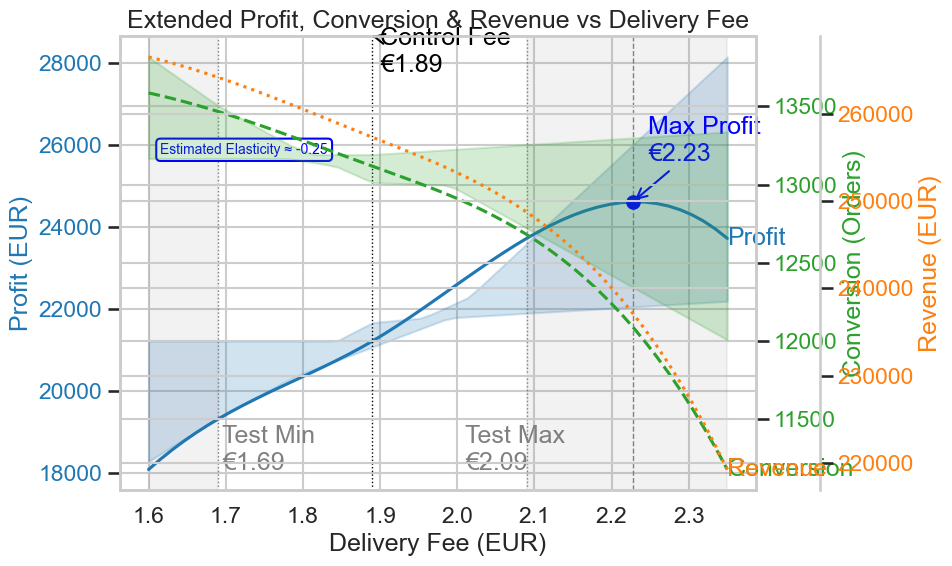

In [465]:
# Extend the range of delivery fees from below the test range (e.g., 1.60) to above (e.g., 2.35)
extended_fees = np.linspace(1.60, 2.35, 50)

# Predict profit, conversion, and revenue over the extended range
extended_profits = profit_interp_func(extended_fees)
extended_conversions = conversion_interp_func(extended_fees)
extended_revenue = extended_conversions * avg_gmv_per_order

# Recalculate bootstrap CIs for extended range
boot_profits_ext = []
boot_conversions_ext = []

for i in range(max_boots):
    sample_df = df.sample(frac=1.0, replace=True)

    # Profit LOWESS and interpolation
    x_sample = sample_df["configured_df"]
    y_sample = sample_df["normalized_profit_eur"]
    lowess_sample = sm.nonparametric.lowess(y_sample, x_sample, frac=0.8, return_sorted=True)
    x_s, y_s = zip(*lowess_sample)
    x_unique, idx = np.unique(x_s, return_index=True)
    if len(x_unique) < 2:
        continue
    y_unique = np.array(y_s)[idx]
    interp_func_profit = interp1d(x_unique, y_unique, kind='linear', fill_value="extrapolate")
    boot_profits_ext.append(interp_func_profit(extended_fees))

    # Conversion LOWESS and interpolation
    y_sample_conv = sample_df["normalized_num_orders"]
    lowess_sample_conv = sm.nonparametric.lowess(y_sample_conv, x_sample, frac=0.8, return_sorted=True)
    x_s_conv, y_s_conv = zip(*lowess_sample_conv)
    x_unique_conv, idx_conv = np.unique(x_s_conv, return_index=True)
    if len(x_unique_conv) < 2:
        continue
    y_unique_conv = np.array(y_s_conv)[idx_conv]
    interp_func_conv = interp1d(x_unique_conv, y_unique_conv, kind='linear', fill_value="extrapolate")
    boot_conversions_ext.append(interp_func_conv(extended_fees))

# Compute CIs
boot_profits_ext = np.array(boot_profits_ext)
boot_conversions_ext = np.array(boot_conversions_ext)

profit_lower_ext = np.percentile(boot_profits_ext, 2.5, axis=0)
profit_upper_ext = np.percentile(boot_profits_ext, 97.5, axis=0)
conv_lower_ext = np.percentile(boot_conversions_ext, 2.5, axis=0)
conv_upper_ext = np.percentile(boot_conversions_ext, 97.5, axis=0)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Profit
color = 'tab:blue'
ax1.set_xlabel('Delivery Fee (EUR)')
ax1.set_ylabel('Profit (EUR)', color=color)
ax1.plot(extended_fees, extended_profits, color=color, label='Profit')
ax1.fill_between(extended_fees, profit_lower_ext, profit_upper_ext, color=color, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)

# Conversion
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Conversion (Orders)', color=color)
ax2.plot(extended_fees, extended_conversions, color=color, linestyle='--', label='Conversion')
ax2.fill_between(extended_fees, conv_lower_ext, conv_upper_ext, color=color, alpha=0.2)
ax2.tick_params(axis='y', labelcolor=color)

# Revenue
ax3 = ax1.twinx()
color = 'tab:orange'
ax3.spines["right"].set_position(("axes", 1.1))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
for spine in ax3.spines.values():
    spine.set_visible(False)
ax3.spines["right"].set_visible(True)

ax3.set_ylabel("Revenue (EUR)", color=color)
ax3.plot(extended_fees, extended_revenue, color=color, linestyle=':', label='Revenue')
ax3.tick_params(axis='y', labelcolor=color)

# 1. Find and annotate profit-maximizing fee
optimal_idx = np.argmax(extended_profits)
optimal_fee = extended_fees[optimal_idx]
optimal_profit = extended_profits[optimal_idx]

ax1.axvline(optimal_fee, color='gray', linestyle='--', linewidth=1)
ax1.scatter(optimal_fee, optimal_profit, color='blue', zorder=5)
ax1.annotate(f"Max Profit\n€{optimal_fee:.2f}",
             xy=(optimal_fee, optimal_profit),
             xytext=(optimal_fee + 0.02, optimal_profit + 1000),
             arrowprops=dict(arrowstyle='->', color='blue'),
             color='blue')

# 2. Label each curve directly
ax1.text(extended_fees[-1], extended_profits[-1], 'Profit', color='tab:blue', va='center')
ax2.text(extended_fees[-1], extended_conversions[-1], 'Conversion', color='tab:green', va='center')
ax3.text(extended_fees[-1], extended_revenue[-1], 'Revenue', color='tab:orange', va='center')

# --- Control Fee Annotation ---
control_fee = df.loc[df["variant"] == "Control", "configured_df"].mean()

ax1.axvline(control_fee, color='black', linestyle=':', linewidth=1)
ax1.annotate(f"Control Fee\n€{control_fee:.2f}",
             xy=(control_fee, ax1.get_ylim()[1]),
             xytext=(control_fee + 0.01, ax1.get_ylim()[1] * 0.97),
             arrowprops=dict(arrowstyle='->', color='black'),
             color='black')


# --- Test Fee Range Annotation ---
test_fee_min = df["configured_df"].min()
test_fee_max = df["configured_df"].max()

# Add vertical lines for test fee range
ax1.axvline(test_fee_min, color='gray', linestyle=':', linewidth=1)
ax1.axvline(test_fee_max, color='gray', linestyle=':', linewidth=1)

# Label the test fee range
ax1.annotate(f"Test Min\n€{test_fee_min:.2f}",
             xy=(test_fee_min, ax1.get_ylim()[0]),
             xytext=(test_fee_min + 0.005, ax1.get_ylim()[0] + 500),
             color='gray')

ax1.annotate(f"Test Max\n€{test_fee_max:.2f}",
             xy=(test_fee_max, ax1.get_ylim()[0]),
             xytext=(test_fee_max - 0.08, ax1.get_ylim()[0] + 500),
             color='gray')


# --- Elasticity annotation ---
ax1.text(extended_fees[1], ax1.get_ylim()[1] * 0.9,
         f"Estimated Elasticity ≈ {elasticity:.2f}",
         color='blue', fontsize=10,
         bbox=dict(facecolor='white', edgecolor='blue', boxstyle='round'))

# --- Extrapolated region shading ---
ax1.axvspan(test_fee_max, extended_fees[-1], color='gray', alpha=0.1, label='Extrapolated Region')
ax1.axvspan(extended_fees[0], test_fee_min, color='gray', alpha=0.1)


plt.title("Extended Profit, Conversion & Revenue vs Delivery Fee")
fig.tight_layout()
plt.show()


Key Takeaways:
✅ Profit peaks around €2.25–€2.30, then starts to flatten or dip.

📉 Conversion drops steadily as fees increase, showing customer sensitivity.

📊 Revenue is relatively stable, but starts declining more noticeably beyond €2.30.

This visualization makes it easy to pinpoint where increasing delivery fees stop being worth it — around €2.25–€2.30 looks like the optimal zone.

In [ ]:
test_df.columns

Index(['dh_platform', 'entity_id', 'country_code', 'created_at',
       'created_date', 'session_id', 'perseus_client_id', 'customer_id',
       'customer_location', 'id', 'variant', 'vertical_parent',
       'total_transactions', 'transaction_id', 'configured_df',
       'delivery_fee_eur', 'dps_delivery_fee_eur', 'profit_eur',
       'travel_time_distance_km', 'travel_time', 'platform_order_code',
       'gfv_eur', 'gmv_eur', 'delivery_costs_eur',
       'fully_loaded_gross_profit_eur', 'has_subscription',
       'subscription_discount_type', 'converted', 'hour', 'day_of_week'],
      dtype='object')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import statsmodels.api as sm

test_df['converted'] = test_df['platform_order_code'].notna().astype(int)


# --- Parameters ---
extended_fees = np.linspace(1.60, 2.35, 50)
avg_gmv_per_order = test_df.loc[test_df['converted'] == 1, 'gmv_eur'].mean()
max_boots = 10

# --- Normalize raw session-level data ---
# Optional: normalize to per-10k sessions later
test_df["converted"] = test_df["converted"].astype(int)

# --- Bootstrap from session-level data ---
boot_profits_ext = []
boot_conversions_ext = []

valid_boots = 0
while valid_boots < max_boots:
    sample_df = test_df.sample(frac=1.0, replace=True)

    # Aggregate by delivery fee
    agg = sample_df.groupby("configured_df").agg(
        sessions=('session_id', 'nunique'),
        conversions=('converted', 'sum'),
        profit=('profit_eur', 'sum')
    ).reset_index()
    agg["conversion_rate"] = agg["conversions"] / agg["sessions"]
    agg["profit_per_session"] = agg["profit"] / agg["sessions"]
    
    # Normalize to per 10k sessions
    agg["normalized_num_orders"] = agg["conversion_rate"] * 10000
    agg["normalized_profit_eur"] = agg["profit_per_session"] * 10000

    x = agg["configured_df"].values
    y_conv = agg["normalized_num_orders"].values
    y_profit = agg["normalized_profit_eur"].values

    # Skip bad samples
    if len(x) < 4:
        continue

    try:
        # LOWESS smoothing + interpolate
        conv_smooth = sm.nonparametric.lowess(y_conv, x, frac=0.8, return_sorted=True)
        profit_smooth = sm.nonparametric.lowess(y_profit, x, frac=0.8, return_sorted=True)

        x_conv, y_conv_smooth = zip(*conv_smooth)
        x_profit, y_profit_smooth = zip(*profit_smooth)

        interp_conv = interp1d(x_conv, y_conv_smooth, kind='cubic', bounds_error=False, fill_value=np.nan)
        interp_profit = interp1d(x_profit, y_profit_smooth, kind='cubic', bounds_error=False, fill_value=np.nan)

        pred_conv = interp_conv(extended_fees)
        pred_profit = interp_profit(extended_fees)

        if np.any(np.isnan(pred_conv)) or np.any(np.isnan(pred_profit)):
            continue

        boot_conversions_ext.append(pred_conv)
        boot_profits_ext.append(pred_profit)
        valid_boots += 1

    except Exception:
        continue

# Convert to arrays
boot_conversions_ext = np.array(boot_conversions_ext)
boot_profits_ext = np.array(boot_profits_ext)

# Point estimates (use full test_df aggregation)
agg_full = test_df.groupby("configured_df").agg(
    sessions=('session_id', 'nunique'),
    conversions=('converted', 'sum'),
    profit=('profit_eur', 'sum')
).reset_index()
agg_full["conversion_rate"] = agg_full["conversions"] / agg_full["sessions"]
agg_full["profit_per_session"] = agg_full["profit"] / agg_full["sessions"]
agg_full["normalized_num_orders"] = agg_full["conversion_rate"] * 10000
agg_full["normalized_profit_eur"] = agg_full["profit_per_session"] * 10000

# Fit LOWESS for final prediction
conv_fit = sm.nonparametric.lowess(agg_full["normalized_num_orders"], agg_full["configured_df"], frac=0.8, return_sorted=True)
profit_fit = sm.nonparametric.lowess(agg_full["normalized_profit_eur"], agg_full["configured_df"], frac=0.8, return_sorted=True)

x_conv_fit, y_conv_fit = zip(*conv_fit)
x_profit_fit, y_profit_fit = zip(*profit_fit)

conversion_interp_func = interp1d(x_conv_fit, y_conv_fit, kind='cubic', fill_value="extrapolate")
profit_interp_func = interp1d(x_profit_fit, y_profit_fit, kind='cubic', fill_value="extrapolate")

# Point predictions
extended_conversions = conversion_interp_func(extended_fees)
extended_profits = profit_interp_func(extended_fees)
extended_revenue = extended_conversions * avg_gmv_per_order

# Compute confidence intervals
profit_lower_ext = np.percentile(boot_profits_ext, 2.5, axis=0)
profit_upper_ext = np.percentile(boot_profits_ext, 97.5, axis=0)
conv_lower_ext = np.percentile(boot_conversions_ext, 2.5, axis=0)
conv_upper_ext = np.percentile(boot_conversions_ext, 97.5, axis=0)

# --- Now you can reuse your same plotting code from before ---
# Just plug in:
# - extended_fees
# - extended_profits + CI
# - extended_conversions + CI
# - extended_revenue


KeyboardInterrupt: 

In [ ]:
import pandas as pd
import numpy as np

# Define the delivery fees you want to compare
fee_candidates = [control_fee, 2.00, 2.10, 2.25,2.23, 2.35]  # or any other points

# Initialize table
table_data = []

# Find control values for lift comparisons
control_idx = np.argmin(np.abs(extended_fees - control_fee))
control_profit = extended_profits[control_idx]
control_revenue = extended_revenue[control_idx]
control_conversion = extended_conversions[control_idx]

for fee in fee_candidates:
    idx = np.argmin(np.abs(extended_fees - fee))
    row = {
        "Fee (€)": extended_fees[idx],
        "Conversion (Orders)": extended_conversions[idx],
        "Revenue (€)": extended_revenue[idx],
        "Profit (€)": extended_profits[idx],
        "Profit Lift vs Control (%)": ((extended_profits[idx] - control_profit) / control_profit) * 100,
        "Revenue Lift vs Control (%)": ((extended_revenue[idx] - control_revenue) / control_revenue) * 100,
        "Conversion Drop vs Control (%)": ((extended_conversions[idx] - control_conversion) / control_conversion) * 100
    }
    table_data.append(row)

# Create DataFrame
comparison_df = pd.DataFrame(table_data)
comparison_df = comparison_df.round(2)

comparison_df

,Fee (€),Conversion (Orders),Revenue (€),Profit (€),Profit Lift vs Control (%),Revenue Lift vs Control (%),Conversion Drop vs Control (%)
0,1.89,13116.41,262328.28,21214.39,0.00,0.00,0.00
1,2.00,12914.81,258296.21,22564.36,6.36,-1.54,-1.54
2,2.11,12632.22,252644.34,23872.85,12.53,-3.69,-3.69
3,2.24,11998.50,239970.05,24595.50,15.94,-8.52,-8.52
4,2.23,12089.42,241788.42,24601.09,15.96,-7.83,-7.83
5,2.35,11177.58,223551.63,23712.13,11.77,-14.78,-14.78


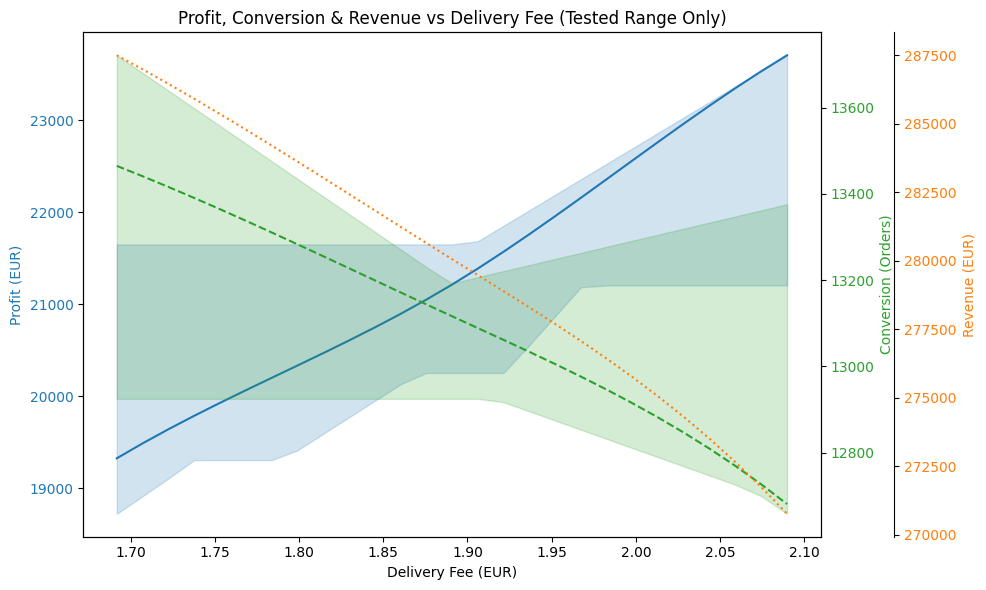

np.float64(2.089795918367347)

In [ ]:
# Restrict to original tested range: 1.69 to 2.09
restricted_mask = (extended_fees >= 1.69) & (extended_fees <= 2.09)
restricted_fees = extended_fees[restricted_mask]
restricted_profits = extended_profits[restricted_mask]
restricted_conversions = extended_conversions[restricted_mask]
restricted_revenue = extended_revenue[restricted_mask]
restricted_profit_lower = profit_lower_ext[restricted_mask]
restricted_profit_upper = profit_upper_ext[restricted_mask]
restricted_conv_lower = conv_lower_ext[restricted_mask]
restricted_conv_upper = conv_upper_ext[restricted_mask]

# Plotting within tested range
fig, ax1 = plt.subplots(figsize=(10, 6))

# Profit
color = 'tab:blue'
ax1.set_xlabel('Delivery Fee (EUR)')
ax1.set_ylabel('Profit (EUR)', color=color)
ax1.plot(restricted_fees, restricted_profits, color=color, label='Profit')
ax1.fill_between(restricted_fees, restricted_profit_lower, restricted_profit_upper, color=color, alpha=0.2)
ax1.tick_params(axis='y', labelcolor=color)

# Conversion
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Conversion (Orders)', color=color)
ax2.plot(restricted_fees, restricted_conversions, color=color, linestyle='--', label='Conversion')
ax2.fill_between(restricted_fees, restricted_conv_lower, restricted_conv_upper, color=color, alpha=0.2)
ax2.tick_params(axis='y', labelcolor=color)

# Revenue
ax3 = ax1.twinx()
color = 'tab:orange'
ax3.spines["right"].set_position(("axes", 1.1))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
for spine in ax3.spines.values():
    spine.set_visible(False)
ax3.spines["right"].set_visible(True)

ax3.set_ylabel("Revenue (EUR)", color=color)
ax3.plot(restricted_fees, restricted_revenue, color=color, linestyle=':', label='Revenue')
ax3.tick_params(axis='y', labelcolor=color)

plt.title("Profit, Conversion & Revenue vs Delivery Fee (Tested Range Only)")
fig.tight_layout()
plt.show()

# Recommend delivery fee that gives max profit within tested range
best_fee_within_range = restricted_fees[np.argmax(restricted_profits)]
best_fee_within_range


Set delivery fee to approximately €2.09 — the highest tested fee — because:

It maximizes profit within your tested range.

Conversion loss is moderate and predictable.



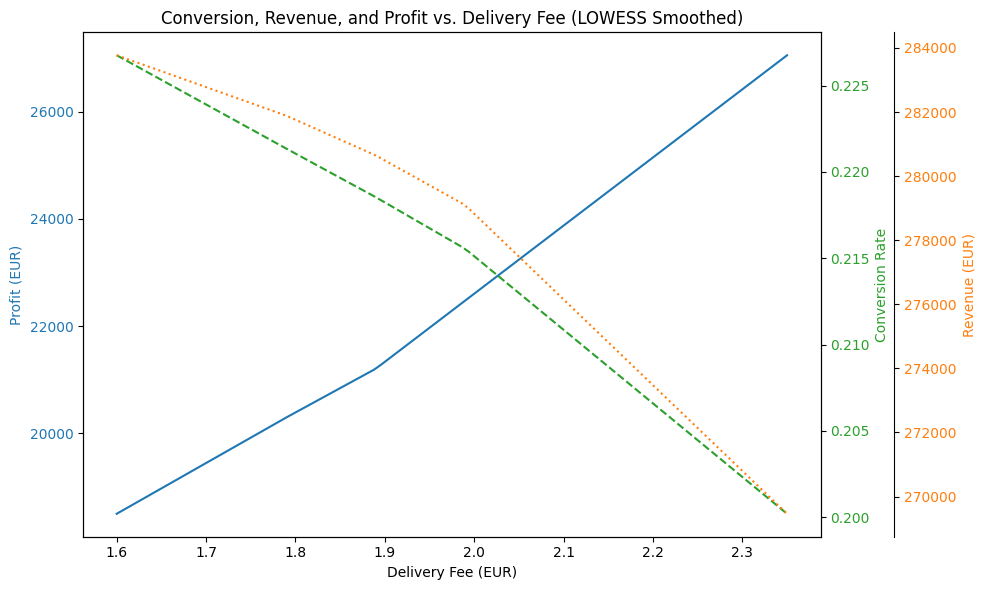

In [ ]:

# LOWESS smoothing
lowess_frac = 0.8
lowess_conversion = sm.nonparametric.lowess(agg["session_to_order_conversion"], agg["configured_df"], frac=lowess_frac, return_sorted=True)
lowess_profit = sm.nonparametric.lowess(agg["normalized_profit_eur"], agg["configured_df"], frac=lowess_frac, return_sorted=True)
lowess_revenue = sm.nonparametric.lowess(agg["normalized_gmv_eur"], agg["configured_df"], frac=lowess_frac, return_sorted=True)

# Interpolate for smooth plotting
fee_range = np.linspace(1.60, 2.35, 100)
interp_conv = interp1d(*zip(*lowess_conversion), fill_value="extrapolate")
interp_profit = interp1d(*zip(*lowess_profit), fill_value="extrapolate")
interp_revenue = interp1d(*zip(*lowess_revenue), fill_value="extrapolate")

curve_conversion = interp_conv(fee_range)
curve_profit = interp_profit(fee_range)
curve_revenue = interp_revenue(fee_range)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Profit
color = 'tab:blue'
ax1.set_xlabel('Delivery Fee (EUR)')
ax1.set_ylabel('Profit (EUR)', color=color)
ax1.plot(fee_range, curve_profit, color=color, label='Profit')
ax1.tick_params(axis='y', labelcolor=color)

# Conversion
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Conversion Rate', color=color)
ax2.plot(fee_range, curve_conversion, color=color, linestyle='--', label='Conversion')
ax2.tick_params(axis='y', labelcolor=color)

# Revenue
ax3 = ax1.twinx()
color = 'tab:orange'
ax3.spines["right"].set_position(("axes", 1.1))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
for spine in ax3.spines.values():
    spine.set_visible(False)
ax3.spines["right"].set_visible(True)

ax3.set_ylabel("Revenue (EUR)", color=color)
ax3.plot(fee_range, curve_revenue, color=color, linestyle=':', label='Revenue')
ax3.tick_params(axis='y', labelcolor=color)

plt.title("Conversion, Revenue, and Profit vs. Delivery Fee (LOWESS Smoothed)")
fig.tight_layout()
plt.show()

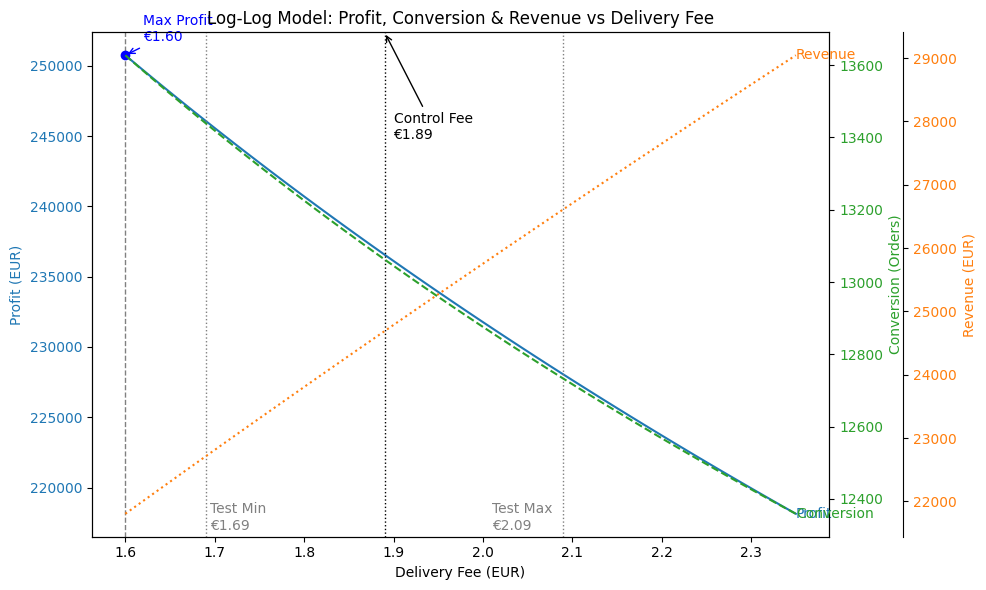

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd

# Simulate representative data structure for log-log input
df_log = pd.DataFrame({
    "configured_df": [1.89, 2.09, 1.69, 1.99, 1.79],
    "session_to_order_conversion": [0.219249, 0.211102, 0.224464, 0.216000, 0.218723],
    "normalized_num_orders": [13192.0, 12701.79, 13505.75, 12996.5, 13160.37]
})

# Total session volume (approximate) to simulate total revenue/profit
total_sessions = 60000
avg_gmv_per_order = 20.0

# Fit log-log model
df_log["log_fee"] = np.log(df_log["configured_df"])
df_log["log_conv"] = np.log(df_log["session_to_order_conversion"])
X = sm.add_constant(df_log["log_fee"])
y = df_log["log_conv"]
model = sm.OLS(y, X).fit()
alpha, beta = model.params["const"], model.params["log_fee"]

# Extended fee range
extended_fees = np.linspace(1.60, 2.35, 50)
log_fees = np.log(extended_fees)

# Predict conversion
log_conv_preds = alpha + beta * log_fees
extended_conversions = np.exp(log_conv_preds) * total_sessions

# Compute revenue and profit
extended_revenue = extended_conversions * extended_fees
extended_profits = extended_conversions * (avg_gmv_per_order - extended_fees)

# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Profit
color = 'tab:blue'
ax1.set_xlabel('Delivery Fee (EUR)')
ax1.set_ylabel('Profit (EUR)', color=color)
ax1.plot(extended_fees, extended_profits, color=color, label='Profit')
ax1.tick_params(axis='y', labelcolor=color)

# Conversion
ax2 = ax1.twinx()
color = 'tab:green'
ax2.set_ylabel('Conversion (Orders)', color=color)
ax2.plot(extended_fees, extended_conversions, color=color, linestyle='--', label='Conversion')
ax2.tick_params(axis='y', labelcolor=color)

# Revenue
ax3 = ax1.twinx()
color = 'tab:orange'
ax3.spines["right"].set_position(("axes", 1.1))
ax3.set_frame_on(True)
ax3.patch.set_visible(False)
for spine in ax3.spines.values():
    spine.set_visible(False)
ax3.spines["right"].set_visible(True)

ax3.set_ylabel("Revenue (EUR)", color=color)
ax3.plot(extended_fees, extended_revenue, color=color, linestyle=':', label='Revenue')
ax3.tick_params(axis='y', labelcolor=color)

# Max profit point
optimal_idx = np.argmax(extended_profits)
optimal_fee = extended_fees[optimal_idx]
optimal_profit = extended_profits[optimal_idx]

ax1.axvline(optimal_fee, color='gray', linestyle='--', linewidth=1)
ax1.scatter(optimal_fee, optimal_profit, color='blue', zorder=5)
ax1.annotate(f"Max Profit\n€{optimal_fee:.2f}",
             xy=(optimal_fee, optimal_profit),
             xytext=(optimal_fee + 0.02, optimal_profit + 1000),
             arrowprops=dict(arrowstyle='->', color='blue'),
             color='blue')

# Label each curve directly
ax1.text(extended_fees[-1], extended_profits[-1], 'Profit', color='tab:blue', va='center')
ax2.text(extended_fees[-1], extended_conversions[-1], 'Conversion', color='tab:green', va='center')
ax3.text(extended_fees[-1], extended_revenue[-1], 'Revenue', color='tab:orange', va='center')

# Annotate control and test fee range
control_fee = 1.89
test_fee_min = 1.69
test_fee_max = 2.09

ax1.axvline(control_fee, color='black', linestyle=':', linewidth=1)
ax1.annotate(f"Control Fee\n€{control_fee:.2f}",
             xy=(control_fee, ax1.get_ylim()[1]),
             xytext=(control_fee + 0.01, ax1.get_ylim()[1] * 0.97),
             arrowprops=dict(arrowstyle='->', color='black'),
             color='black')

ax1.axvline(test_fee_min, color='gray', linestyle=':', linewidth=1)
ax1.axvline(test_fee_max, color='gray', linestyle=':', linewidth=1)

ax1.annotate(f"Test Min\n€{test_fee_min:.2f}",
             xy=(test_fee_min, ax1.get_ylim()[0]),
             xytext=(test_fee_min + 0.005, ax1.get_ylim()[0] + 500),
             color='gray')

ax1.annotate(f"Test Max\n€{test_fee_max:.2f}",
             xy=(test_fee_max, ax1.get_ylim()[0]),
             xytext=(test_fee_max - 0.08, ax1.get_ylim()[0] + 500),
             color='gray')

plt.title("Log-Log Model: Profit, Conversion & Revenue vs Delivery Fee")
fig.tight_layout()
plt.show()


In [ ]:
# import matplotlib.pyplot as plt

# # Step 1: Filter valid data and deduplicate by order
# tmp_valid = tmp[~tmp['travel_time_distance_km'].isnull()]
# tmp_unique_orders = tmp_valid.drop_duplicates('platform_order_code')

# # Step 2: Get list of variants
# variants = tmp_unique_orders['variant'].unique()

# # Step 3: Create subplots
# n_variants = len(variants)
# fig, axes = plt.subplots(n_variants, 1, figsize=(10, 4 * n_variants), sharex=True)

# # Plot each variant in a separate subplot
# for i, variant in enumerate(sorted(variants)):
#     ax = axes[i] if n_variants > 1 else axes
#     data = tmp_unique_orders[tmp_unique_orders['variant'] == variant]
#     ax.hist(data['travel_time_distance_km'], bins=30, edgecolor='black')
#     ax.set_title(f'Distribution for Variant: {variant}')
#     ax.set_ylabel('Unique Orders')
#     ax.grid(True)

# axes[-1].set_xlabel('Travel Time Distance (km)')
# plt.tight_layout()
# plt.show()


In [ ]:
# agg_data = test_df.groupby(['created_date','session_id','variant','configured_df']).agg({'transaction_id':'nunique'}).reset_index()

# final_data = agg_data.groupby(['created_date','variant', 'configured_df']).agg(
#     total_sessions=('session_id', 'nunique'),
#     converted_sessions=('session_id', lambda x: x[agg_data.loc[x.index, 'transaction_id'] > 0].nunique())
# ).reset_index()

# final_data['session_to_order_conversion'] = round(final_data['converted_sessions'] / final_data['total_sessions'],2)

# final_data

# # Plotting
# plt.figure(figsize=(12, 6))
# for variant, group in final_data.groupby('variant'):
#     plt.plot(group['created_date'], group['session_to_order_conversion'], marker='o', label=f'Variant {variant}')

# plt.title('Session-to-Order Conversion Rate (CVR) by Variant')
# plt.xlabel('Created Date')
# plt.ylabel('CVR')
# plt.legend(title='Variant')
# plt.grid(True)
# plt.tight_layout()
# plt.xticks(rotation=45)
# plt.show()

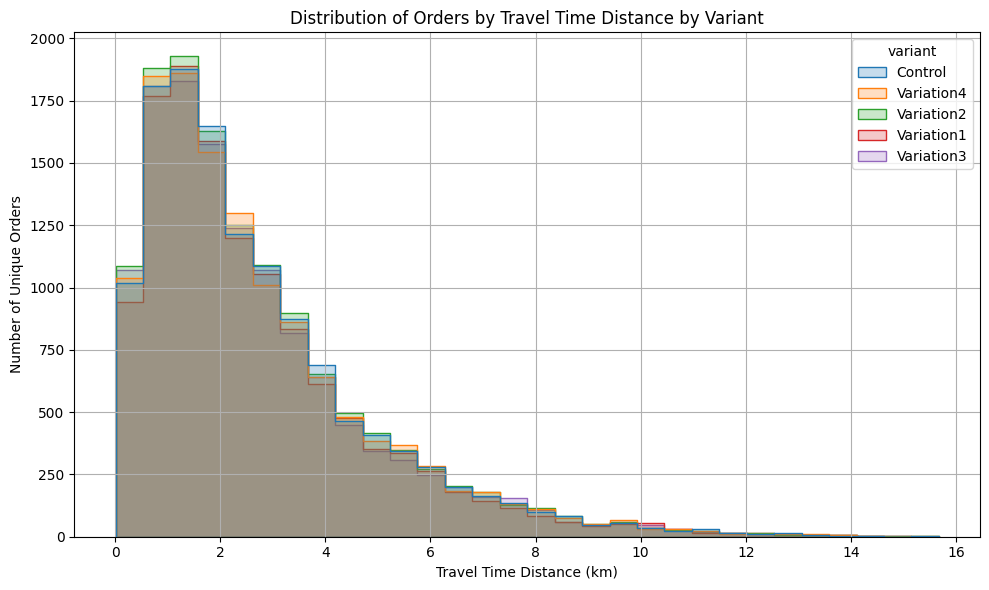

In [ ]:
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.histplot(
    data=tmp_unique_orders,
    x='travel_time_distance_km',
    hue='variant',
    bins=30,
    element='step',
    stat='count',
    common_norm=False
)
plt.xlabel('Travel Time Distance (km)')
plt.ylabel('Number of Unique Orders')
plt.title('Distribution of Orders by Travel Time Distance by Variant')
plt.grid(True)
plt.tight_layout()
plt.show()

/var/folders/7c/hjrbzbpn61jgnsn14y5f3l7c0000gq/T/ipykernel_36262/2806308495.py:15: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['variant', 'distance_bin'])


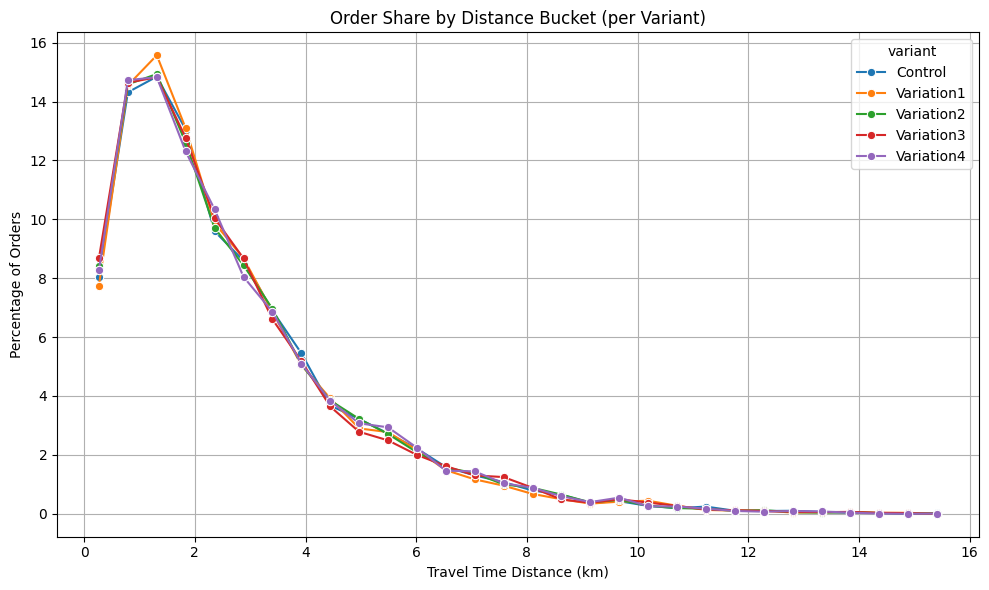

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Define number of bins
bins = 30
bin_edges = np.histogram_bin_edges(tmp_unique_orders['travel_time_distance_km'], bins=bins)

# Create a column for bin labels
tmp_unique_orders['distance_bin'] = pd.cut(tmp_unique_orders['travel_time_distance_km'], bins=bin_edges, include_lowest=True)

# Count orders per bin per variant
bin_counts = (
    tmp_unique_orders
    .groupby(['variant', 'distance_bin'])
    .size()
    .reset_index(name='count')
)

# Total orders per variant
variant_totals = bin_counts.groupby('variant')['count'].sum().reset_index(name='total')

# Merge totals into bin_counts to compute percentage
bin_counts = bin_counts.merge(variant_totals, on='variant')
bin_counts['percent'] = 100 * bin_counts['count'] / bin_counts['total']

# Use midpoints of bins for x-axis
bin_counts['bin_mid'] = bin_counts['distance_bin'].apply(lambda x: x.mid)

# Plot
plt.figure(figsize=(10, 6))
sns.lineplot(
    data=bin_counts,
    x='bin_mid',
    y='percent',
    hue='variant',
    marker='o'
)
plt.xlabel('Travel Time Distance (km)')
plt.ylabel('Percentage of Orders')
plt.title('Order Share by Distance Bucket (per Variant)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
# from geopy.geocoders import Nominatim

# # Create geocoder
# geolocator = Nominatim(user_agent="geoapi")

# # Coordinates: (latitude, longitude)
# location = geolocator.reverse((35.1090751334876, 33.288642950356), exactly_one=True)

# # Print address details
# print(location.address)

# # Optionally extract city, town, or village
# city = location.raw.get('address', {}).get('city') or \
#        location.raw.get('address', {}).get('town') or \
#        location.raw.get('address', {}).get('village') or \
#        location.raw.get('address', {}).get('municipality')

# print("City:", city)